# Investigating the Variability of Spider Light Curves in TESS Fields

Name: Ethan O'Mahony. Student Number: 121382523

This code finds the light curves available for a system from the TESS mission catalog in the MAST database and performs analysis on them.

In [79]:
# Imports necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.timeseries import LombScargle
from scipy import optimize

### Required Inputs from the user:
* The name of the system under investigation: system_name
* Time of pulsar ascending node in TBJD: T0
* The orbital period of the system (use radio if available): system_period

### My systems:

| System Name    | T0 | Radio Orbital Period | 'Spectroscopic Orbital Period |
| :--------: | :-------: | :-------: | :-------: |
| 3FGL J0212.1+5320  | 1487.956799    | 0.8695759(11) [1] |
| 3FGL J0523.3-2528 | -422.5256735    |  | 0.688134(28) [2]|

### Required Initial Parameters

In [253]:
# Required initial parameters for the system
system_name = "3FGL J0212.1+5320"
T0 = 1487.956799

# Choose radio_period if available (more accurate)
system_period = 0.8695759

### Obtaining the File for the System

Occasionally running the cell to query the database times out, but running it again fixes the issue. (Seemingly just internet speed dependent).

In [270]:
# Searches the TESS mission catalog within the MAST database for the system, with a window of radius 0.2 degrees
observations = Observations.query_object(system_name, radius = "0.2 deg")

# Creates a filter to get the obs_id and target_name (TIC ID) for the system
obs_wanted = ( (observations['dataproduct_type'] == 'timeseries') & (observations['obs_collection'] == 'TESS') )

print(observations[obs_wanted]['obs_id','target_name'])

                     obs_id                     target_name
----------------------------------------------- -----------
tess2018319095959-s0005-0000000031091702-0125-s    31091702
tess2018349182500-s0006-0000000031091702-0126-s    31091702
tess2018319095959-s0005-0000000031090358-0125-s    31090358
tess2020324010417-s0032-0000000031090358-0200-s    31090358


Note: If multiple obs_id files are available for your object then you can go through the list by varying $i \in \mathbb{N}$ in observations[obs_wanted]['obs_id'][i]. 
($i=0$ is the first file).

In [305]:
# Builds the link for obtaining the fits file for the light curves 
start_link = 'https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/'
obs_id_str = observations[obs_wanted]['obs_id'].tolist()[0]
end_link = '_lc.fits'

fits_file = start_link + obs_id_str + end_link

In [306]:
# Extracts the data wanted for the light curves from the fits file (hdulist = Header/Data Unit list)
with fits.open(fits_file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    
#tess_bjds are the time points for each flux reading in TBJD. 
#pdcsap_fluxes are the flux values, nominally corrected for instrumental variations. 
#pdcsap_fluxes_err are the error values for the flux values

### Removing nan values from the time and flux arrays

In [307]:
#Applies a series of masks to each of the arrays to remove any possible nan values from them
#Flux nans - tidied
mask1 = ~np.isnan(pdcsap_fluxes) 
tidied_flux = pdcsap_fluxes[mask1]
tidied_time = tess_bjds[mask1]
tidied_errors = pdcsap_fluxes_err[mask1]

#Flux error nans - flux_tidied
mask2 = ~np.isnan(tidied_errors) 
flux_tidied_flux = tidied_flux[mask2]
flux_tidied_time = tidied_time[mask2]
flux_tidied_errors = tidied_errors[mask2]

# Time nans - nan_tidied
mask3 = ~np.isnan(flux_tidied_time) 
nan_tidied_flux = flux_tidied_flux[mask3]
nan_tidied_time = flux_tidied_time[mask3]
nan_tidied_errors = flux_tidied_errors[mask3]

### Analysing the Light Curve for Variance

#### Defining some important values:

In [308]:
# Defines some important values for working with the data for the system

P = system_period                         # Defines the period as the orbital period entered at the begining

days_after_T0 = (tess_bjds[0] - T0)       # How many days passed between T0 and TESS's first recording of our system [TBJD]

periods_passed = days_after_T0/P          # How many periods have passed

N = (int(periods_passed))                 # Integer number of periods passed

T0_alt = T0 + N*P                         # Add on the closest integer number of periods to T0 to find the first/nearest 
                                          # pulsar ascending node (phase = 0) available in the observations --> T0_alt (alt standing for alternative) [TBJD]

n_cycles = int(((nan_tidied_time[-1]) - (nan_tidied_time[0])) / P) + 1   # Finds the number of orbital cycles available from the tidied data 

xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'  # x-axis label for a lot of the plots

ylabel = r"Flux [$e^-s^{-1}$]"            # y-axis label for a lot of the plots. [e^-/s]:(electrons per second)

#### Whole Light Curve:

Text(0, 0.5, 'Flux [$e^-s^{-1}$]')

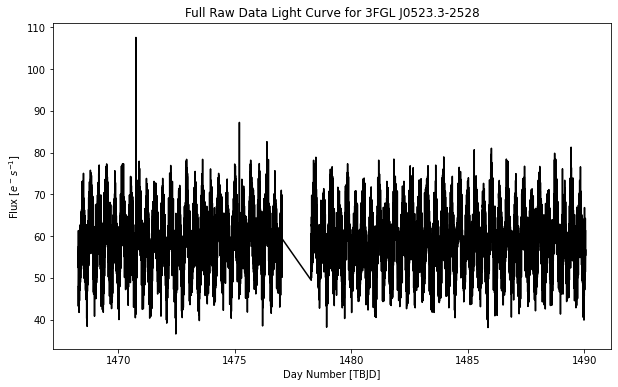

In [309]:
# Plots the full available light curve for the system
plt.figure(figsize=(10, 6))
plt.plot(nan_tidied_time,nan_tidied_flux, color='k')
plt.title("Full Raw Data Light Curve for " + str(system_name))
plt.xlabel("Day Number [TBJD]")
plt.ylabel(ylabel)

#### Waterfall:

Text(0.5, 1.0, 'Waterfall Plot for 3FGL J0523.3-2528')

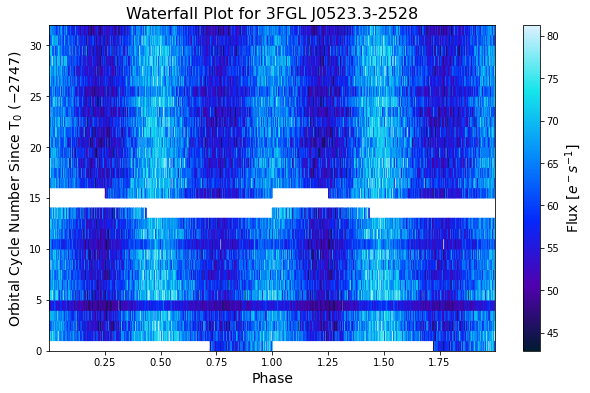

In [310]:
# Calculates the phase in sections of 0 to 1 for each orbital cycle
phase = ((nan_tidied_time - T0_alt) / P) % 1  

# Creates a custom color map for the heatmap (pcolormesh). I found values for the colours of ["blue near black","mid range blue","blue near white"]
#custom_cmap = LinearSegmentedColormap.from_list("custom", ["#011B31", "#058CFB", "#DDF0FF"])
# Then made one with five colours to try and extend the variability of the waterfall. Can't decide which is better. But below has similar colours to the 3-colour one, with the addition of 2 darker colours, and one lighter.
custom_cmap = LinearSegmentedColormap.from_list("custom", ["#011B31", "#5001AF" , "#0528FB" ,"#058CFB", "#16E5EA","#DDF0FF"])


plt.figure(figsize=(10, 6))


# Creates a mask with the time stamps of each cycle number. Stacks each cycle on top of each other in "Waterfall" Plot
for cycle in range(n_cycles):                      
    start_time = T0_alt + cycle * P                 
    end_time = T0_alt + (cycle + 1) * P
    mask = (nan_tidied_time >= start_time) & (nan_tidied_time < end_time)    
    phase_cycle = phase[mask]                                 
    flux_cycle = nan_tidied_flux[mask]
    
    # Ensures that flux_cycle with enirely nan values are "ignored" (not doing this occasionally caused problems, but an empty orbital cycle will be plot on the waterfall still so it is fine to do as a precaution)
    if len(flux_cycle > 0):
        plt.pcolormesh(phase_cycle,[cycle,cycle+1.0],[flux_cycle,flux_cycle],cmap=custom_cmap, shading='gouraud')  #Plots phase 0-1
        plt.pcolormesh(phase_cycle+1,[cycle,cycle+1.0],[flux_cycle,flux_cycle],cmap=custom_cmap,shading='gouraud') #Plots phase "1-2" 


# Creates the waterfall plot
cbar = plt.colorbar()
cbar.set_label(ylabel, size=14)
plt.xlabel('Phase', size=14)
plt.ylabel(xlabel, size=14)
plt.title('Waterfall Plot for ' + str(system_name), size=16)

#### Plotting the Light Curves for Some of the Orbital Cycles (2-6) with Errors:

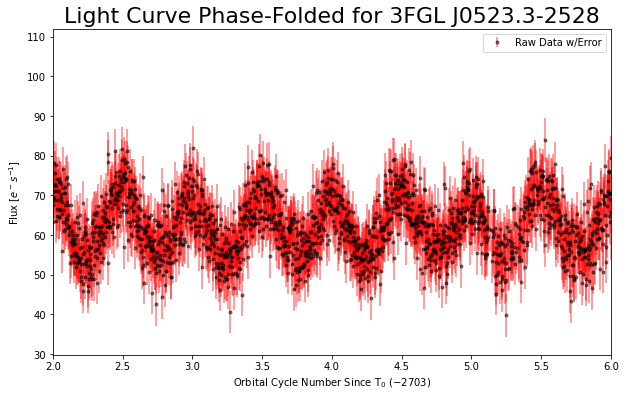

In [292]:
# Phase folds the data into orbital cycles measured in N.0 to (N+1).0 for N in n_cycles. 
phase = ((nan_tidied_time - T0_alt) / P)

phases = []
fluxes = []
errors = []
cycles = []

for cycle in range(n_cycles):                      
    start_time = T0_alt + cycle * P                 
    end_time = T0_alt + (cycle + 1) * P
    mask = (nan_tidied_time >= start_time) & (nan_tidied_time < end_time)    
    phase_cycle = phase[mask]                                 
    flux_cycle = nan_tidied_flux[mask]
    error_cycle = nan_tidied_errors[mask]
    phases = np.append(phases,phase_cycle)
    fluxes = np.append(fluxes,flux_cycle)
    errors = np.append(errors,error_cycle)
    cycles = np.append(cycles,cycle)
    

plt.figure(figsize=(10, 6))
plt.errorbar(phases, fluxes, yerr=errors, fmt='k.', ecolor='r', label="Raw Data w/Error", alpha=0.5)
plt.title("Light Curve Phase-Folded for " + str(system_name), size=22)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(cycles[2],cycles[6])
plt.legend()

### Lomb-Scargle Periodogram Testing the Orbital Period

In [293]:
# Performs a Lomb-Scargle Periodogram (LSP) on the data to get an approximation of the period of the system
frequency, power = LombScargle(nan_tidied_time, nan_tidied_flux, nterms=2).autopower(samples_per_peak=20,maximum_frequency=1/(5/(60*24) ))

# LombScargle() [3][4]

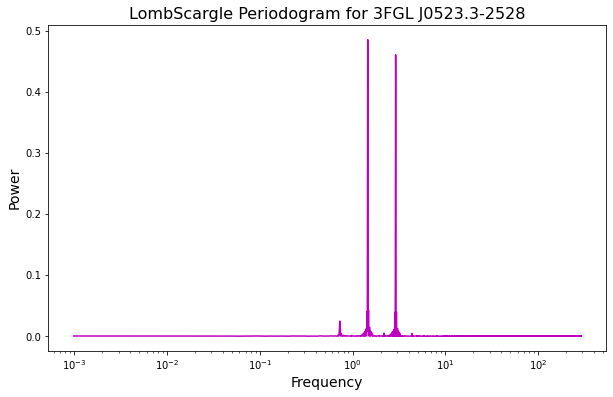

In [294]:
#Plot of the power vs frequency found from the LSP
plt.figure(figsize=(10, 6))
plt.title("LombScargle Periodogram for " + system_name, size = 16)
plt.plot(frequency,power, label = "Frequency vs Power",color='m')
plt.xlabel("Frequency", size = 14)
plt.ylabel("Power", size = 14)
plt.xscale('log')
plt.savefig("J0523LombScargle.pdf")

In [295]:
# Finds the initial approximation for the period of the system from the max power found by the LSP
max_index = np.argmax(power)
max_frequency = frequency[max_index]
B1 = 1/max_frequency
print("Period Initial Guess:",B1)

Period Initial Guess: 0.6879070769017899


### Fitting an Optimised Double Sine Function to the Data
#### Fitting a model to the entire data set:

Fitted parameters: A=-1.5930983083011938, B=0.6880309539290804, C=-0.5846413926812963, D=6.754520450519851, E=-2.145823982929401, F=61.97619870747246 

Reduced χ2: 0.8424107719068515 



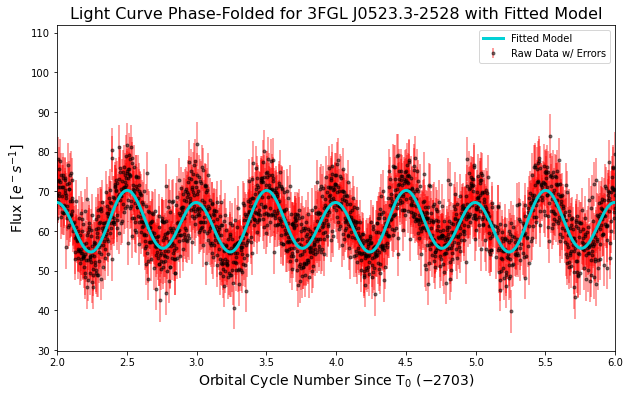

In [296]:
# Test function to build a model approximating the data. The function is of the form sine(With Period P) + sine(With Period (P/2))

# f = (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# A is the amplitude of the first harmonic. B is the period.
# C is the phase offset of the first harmonic. D is the amplitide of the second harmonic.
# E is the phase offset of the second harmonic. F shifts the central y-axis value of the test function up to the average 
# flux of the data set.

# Defines the test function that the model will approximate
def test_func(x, A, B, C, D, E, F):
    return (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

#Number of varying parameters in the model
num_params = 6

#Initial guesses for the parameters of the model
averageflux = np.mean(nan_tidied_flux)
A = 4
B = P 
C = 1
D = 16
E = 1
F = averageflux

# Assigning our initial guesses for the parameters into an array
init_vals = [A,B,C,D,E,F]


#Uses our test function with scipy's optimize.curve_fit to create a model for the dataset                                                                ###Bounds broke this model and any single sine models to follow for some reason (worked here occasionally if it was in the mood)
params, params_covariance = optimize.curve_fit(test_func, nan_tidied_time, nan_tidied_flux, init_vals, nan_tidied_errors) #,bounds = ([0,0,-np.pi,0,-np.pi,0],[np.inf,np.inf,np.pi,np.inf,np.pi,np.inf]))


# Extracts the parameter fit values and covariance matrix values for each parameter
A_fit, B_fit, C_fit, D_fit, E_fit, F_fit = params
A_cov, B_cov, C_cov, D_cov, E_cov, F_cov = params_covariance

print(f"Fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}, E={E_fit}, F={F_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(nan_tidied_time, A_fit, B_fit, C_fit, D_fit, E_fit, F_fit)

# Finds the reduced chi**2 value for the test model
r_chi_squared = (np.sum(((fluxes-y_fit)/(errors))**2))/(len(y_fit)-num_params)
print("Reduced \u03C72:",r_chi_squared,"\n")

# Plots the tidied data with errorbars vs time, and the model vs time
plt.figure(figsize=(10, 6))
plt.errorbar(phases, fluxes, yerr=errors, fmt='k.', ecolor = 'r', label="Raw Data w/ Errors", alpha=0.5)
plt.plot(phases,y_fit,label="Fitted Model", lw=3, color='#02D1D6', zorder=5)
plt.legend()
plt.title("Light Curve Phase-Folded for " + str(system_name) + " with Fitted Model", size=16)
plt.xlabel(xlabel, size=14)
plt.ylabel(ylabel, size=14)
plt.xlim(cycles[2],cycles[6])
plt.xlim()
plt.savefig("J0212LCwModel.pdf")

In [297]:
# Propagation of errors formula to get the error of the model from the covariance matrices

# The function f:
# f = (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# Values of our parameters
x = nan_tidied_time
A = A_fit
B = B_fit
C = C_fit
D = D_fit
E = E_fit 
F = F_fit

# Partial derivatives of f. where f (the fit) diffrentiated with respect to A is represented as: fwA, etc.
fwA = np.sin(2*np.pi/B * x + C)  
fwB = -((2*np.pi*x*(2*E*np.cos(4*np.pi/B * x + F) + A*np.cos(2*np.pi/B * x + C)))/(B**2))
fwC = A*np.cos(2*np.pi/B * x + C)
fwD = 1
fwE = np.sin(4*np.pi/B * x + F)
fwF = E*np.cos(4*np.pi/B * x + F)

# Propagation of errors formula
y_fit_err = np.sqrt( (fwA**2)*(A_cov[0]) + (fwB**2)*(B_cov[1]) + (fwC**2)*(C_cov[2]) + (fwD**2)*(D_cov[3]) + (fwE**2)*(E_cov[4]) + (fwF**2)*(F_cov[5]) + 2*fwA*fwB*(A_cov[1]) + 2*fwA*fwC*(A_cov[2]) + 2*fwA*fwD*(A_cov[3]) + 2*fwA*fwE*(A_cov[4]) + 2*fwA*fwF*(A_cov[5]) + 2*fwB*fwC*(B_cov[2]) + 2*fwB*fwD*(B_cov[3]) + 2*fwB*fwE*(B_cov[4]) + 2*fwB*fwF*(B_cov[5]) + 2*fwC*fwD*(C_cov[3]) + 2*fwC*fwE*(C_cov[4]) + 2*fwC*fwF*(C_cov[5]) + 2*fwD*fwE*(D_cov[4]) + 2*fwD*fwF*(D_cov[5]) + 2*fwE*fwF*(E_cov[5]))

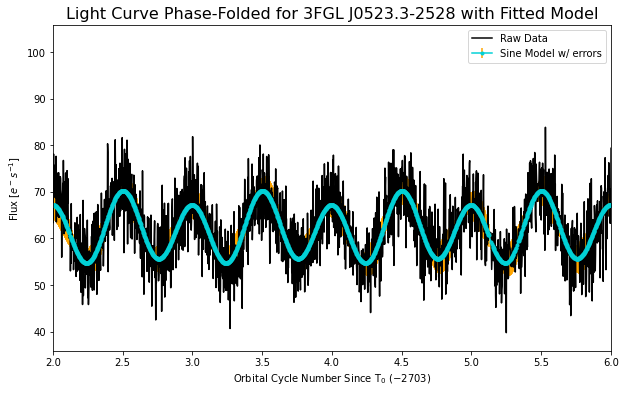

In [298]:
# Plots the model with errorbars and the tidied data vs time
plt.figure(figsize=(10, 6))
plt.errorbar(phases, y_fit, y_fit_err, color='#02D1D6', marker='.', ecolor = 'orange', label = "Sine Model w/ errors") # Place 3* in front of the y_fit_err to check the errors to the 3 sigma level
plt.plot(phases, fluxes, color='k', label="Raw Data")
plt.title("Light Curve Phase-Folded for " + str(system_name) + " with Fitted Model", size=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(cycles[2],cycles[6])
plt.legend()

#### Fitting a Model to Each Phase of the Data Individually:

This one just shows plots with the full model.

Cycle Number: 1 

Fitted parameters: A=1.1358679552785285e-08, B=0.6881001529405621, C=3.1354031850601576, D=14.318255144426423, E=0.9634109064879774, F=51.67792493820965

Reduced χ2: 0.758206583876951 



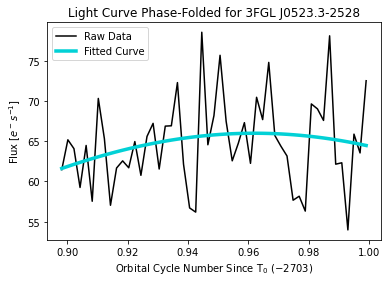

Cycle Number: 2 

Fitted parameters: A=1.862382189572791, B=0.6881703692398756, C=-1.0989780577257044, D=6.224516712337375, E=3.1415842443968773, F=62.03273295064621

Reduced χ2: 0.7708350547153242 



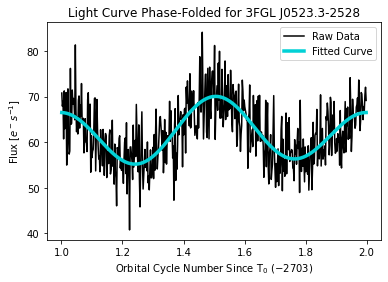

Cycle Number: 3 

Fitted parameters: A=0.9510257269236014, B=0.6881687748654658, C=-0.7971472182056037, D=7.721822903384495, E=3.141592652040682, F=62.69238759868542

Reduced χ2: 0.8926000046159973 



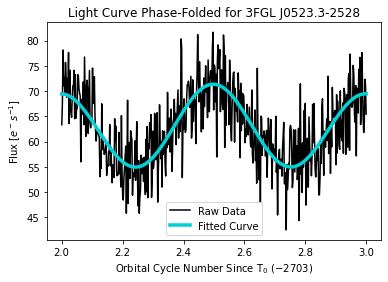

Cycle Number: 4 

Fitted parameters: A=1.2708921075919282, B=0.6881698907229434, C=-1.4333409973366444, D=7.068879451945577, E=3.1415542026010153, F=61.80485402711664

Reduced χ2: 0.8270215811152375 



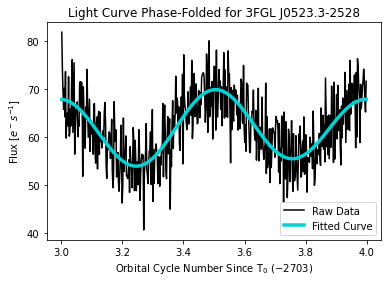

Cycle Number: 5 

Fitted parameters: A=1.7311936692415073, B=0.688168105195262, C=-1.397414176623398, D=6.727887528664707, E=3.141592653234338, F=62.3328413909019

Reduced χ2: 0.7949798846412883 



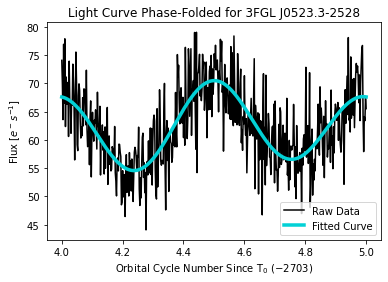

Cycle Number: 6 

Fitted parameters: A=2.109073510081456, B=0.6881694720054358, C=-0.9674404970358597, D=7.298334633955247, E=3.1415631996258018, F=61.865095518595034

Reduced χ2: 0.9136811532913559 



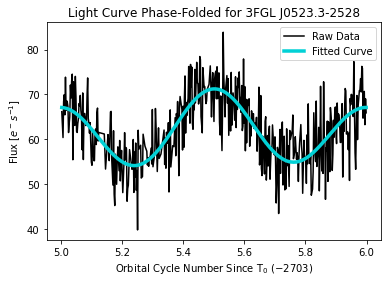

Cycle Number: 7 

Fitted parameters: A=1.6780344309197823, B=0.6881667999883643, C=-1.4376583745670886, D=6.285454541406067, E=3.000854204271995, F=61.84181052696069

Reduced χ2: 0.8997972316246371 



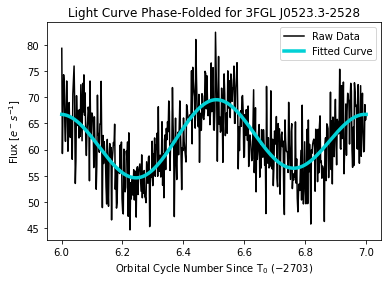

Cycle Number: 8 

Fitted parameters: A=1.9968770027259464, B=0.6881673033997424, C=-1.1489548183470228, D=6.858521599776367, E=3.141569547728417, F=62.08740872012586

Reduced χ2: 0.8280245368171404 



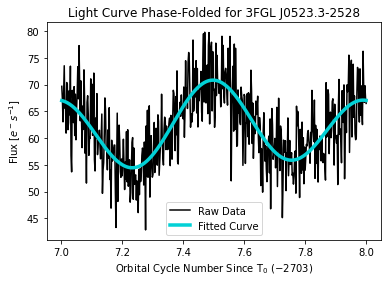

Cycle Number: 9 

Fitted parameters: A=1.818334643046354, B=0.6881669952803556, C=-1.374807468357053, D=6.765910252672345, E=3.141592652371002, F=62.108415055209164

Reduced χ2: 0.8456617884030504 



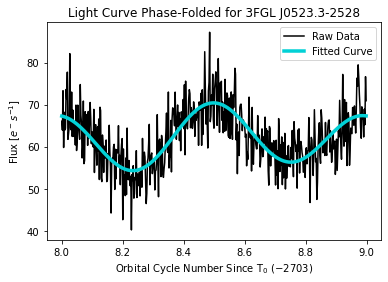

Cycle Number: 10 

Fitted parameters: A=1.7073507103328764, B=0.6880552446397815, C=-3.141540592415639, D=7.147196420714121, E=-1.200566998823632, F=61.54284045637657

Reduced χ2: 0.8190090098949018 



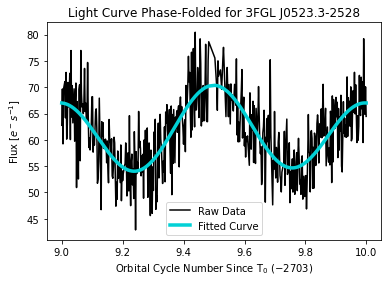

Cycle Number: 11 

Fitted parameters: A=1.9025381189988964, B=0.6881694967274594, C=-0.8559720160756188, D=7.067285645725854, E=3.141592588381945, F=62.27300382220402

Reduced χ2: 0.9570954882907611 



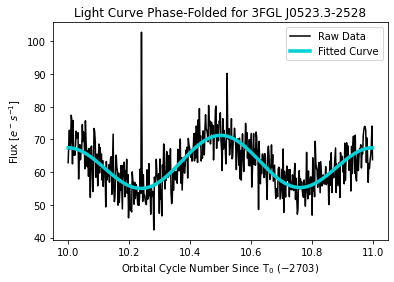

Cycle Number: 12 

Fitted parameters: A=0.9811710650238749, B=0.6881689241057762, C=-0.8891894130382311, D=6.77419486111966, E=3.1415926535628236, F=61.40724216758872

Reduced χ2: 0.8213660250409267 



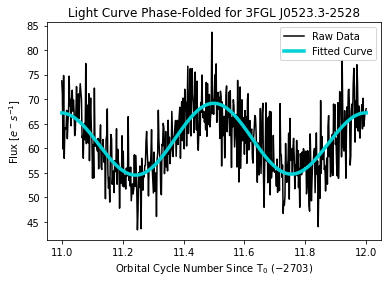

Cycle Number: 13 

Fitted parameters: A=1.349135966422016, B=0.6881694711830685, C=-0.9837225176898602, D=6.232228514559898, E=3.1415853254847703, F=61.894652043354974

Reduced χ2: 0.7841258740264219 



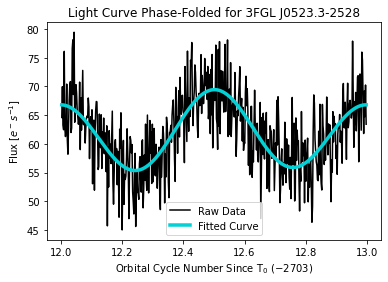

Cycle Number: 14 

Fitted parameters: A=1.5529254287132124, B=0.6881687392352435, C=-1.1585858823205657, D=6.792840133390026, E=3.141592651381256, F=61.995851297009715

Reduced χ2: 0.8570899207589124 



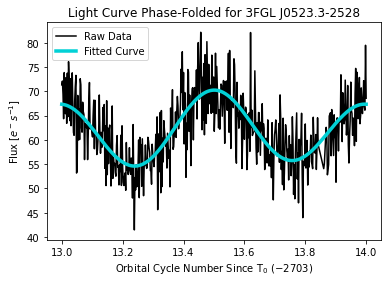

Cycle Number: 15 

Fitted parameters: A=1.3159790525759771, B=0.6881685864034619, C=-1.2266605773693502, D=6.508919338206024, E=3.1415629578041795, F=62.07899140881824

Reduced χ2: 0.9232219828790725 



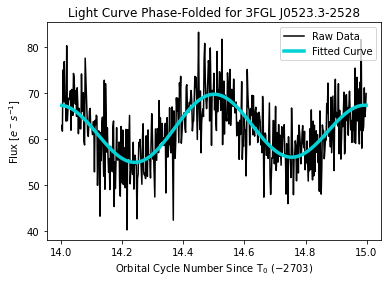

Cycle Number: 16 

Fitted parameters: A=1.2742962929337547, B=0.6880583113779869, C=-3.141592653549876, D=6.976417394984657, E=-1.1335350949878145, F=61.94532405308092

Reduced χ2: 0.8636066841303395 



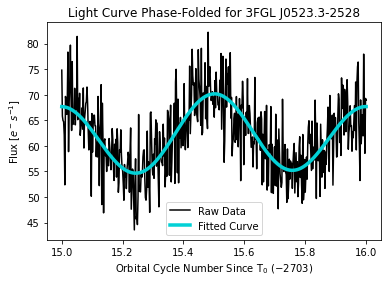

Cycle Number: 17 

Fitted parameters: A=1.3131351424146454, B=0.6880669182789361, C=-3.1415926197144874, D=7.182934918433638, E=-0.7066703621280285, F=61.70922626095157

Reduced χ2: 0.817447923210405 



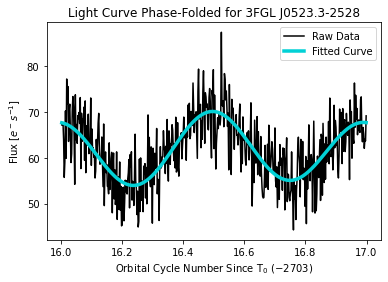

Cycle Number: 18 

Fitted parameters: A=1.660254959726952, B=0.6880575827073044, C=-3.1415887293704756, D=6.973636273428501, E=-1.1290547810235485, F=62.229736838026405

Reduced χ2: 0.9183658567521731 



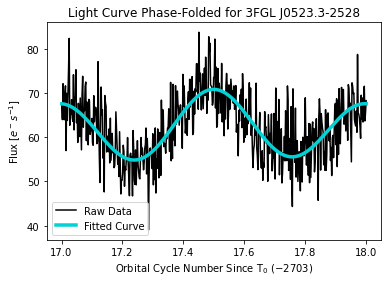

Cycle Number: 19 

Fitted parameters: A=145.18942216791584, B=0.6880913065735393, C=-0.6468165756495606, D=75.26503921814862, E=0.9043101473134387, F=0.001533913347454184

Reduced χ2: 0.9863089052954139 



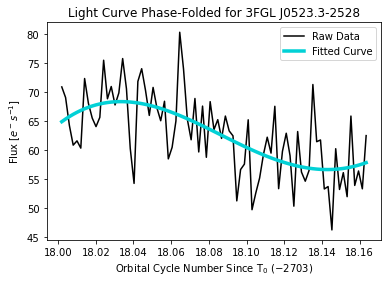

Cycle Number: 20 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number: 20 



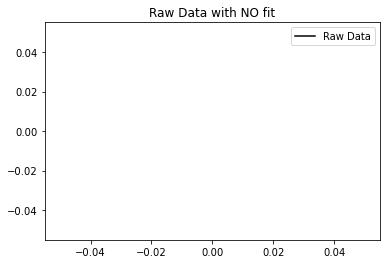

Cycle Number: 21 

Fitted parameters: A=2.246673558369358, B=0.6881687901520505, C=0.47424727406918726, D=5.021171212593489, E=3.141584775849093, F=63.08493630024413

Reduced χ2: 0.8188457897078169 



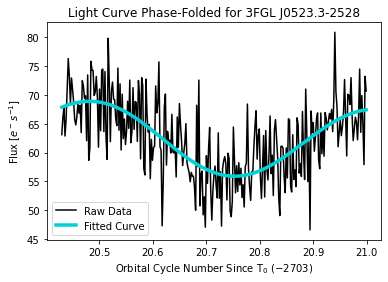

Cycle Number: 22 

Fitted parameters: A=1.4640683862007637, B=0.6881700826507322, C=-1.3287829738185497, D=7.433481383533867, E=3.141512361320078, F=61.94496400277571

Reduced χ2: 0.8404487486506694 



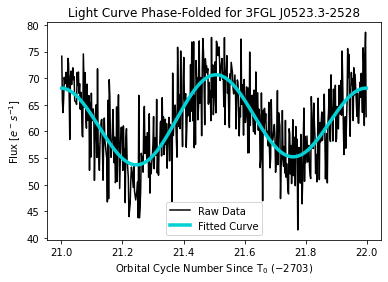

Cycle Number: 23 

Fitted parameters: A=1.72534019386846, B=0.6881680201288501, C=-1.2433560828750225, D=6.926579967550002, E=3.141583107146034, F=61.77329489100255

Reduced χ2: 0.7783236311486409 



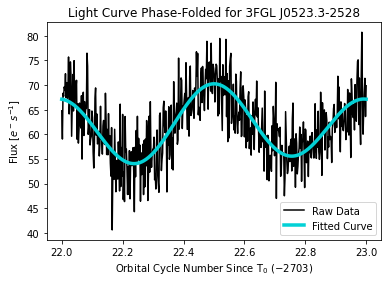

Cycle Number: 24 

Fitted parameters: A=1.6611437668487223, B=0.6881689772830027, C=-1.1690259989585656, D=6.536055020322405, E=3.141566496008112, F=61.91672120318284

Reduced χ2: 0.7050938123662878 



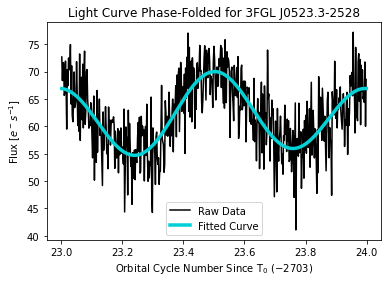

Cycle Number: 25 

Fitted parameters: A=1.0643485812802918, B=0.6881678421518302, C=-1.4013879923197516, D=6.279475887688949, E=3.1415926529367963, F=62.03653840190005

Reduced χ2: 0.9911863526222288 



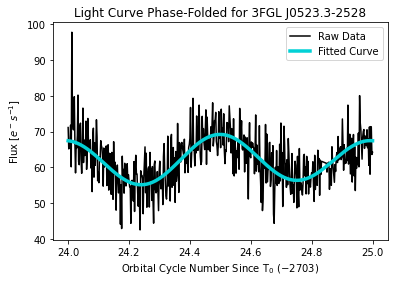

Cycle Number: 26 

Fitted parameters: A=1.6993249273351436, B=0.6881680061480986, C=-1.0545190323773384, D=6.824977817290787, E=3.1415925923184385, F=62.00317643696062

Reduced χ2: 0.8002142152831137 



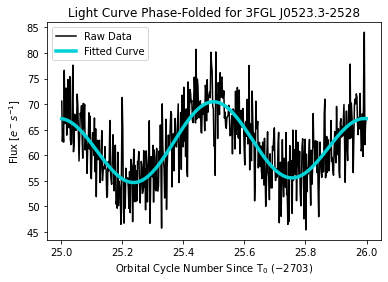

Cycle Number: 27 

Fitted parameters: A=1.712445116376814, B=0.6880550049566085, C=-3.141592601392278, D=6.471837336757683, E=-1.2044355279852579, F=61.88002379347743

Reduced χ2: 0.7639633881578499 



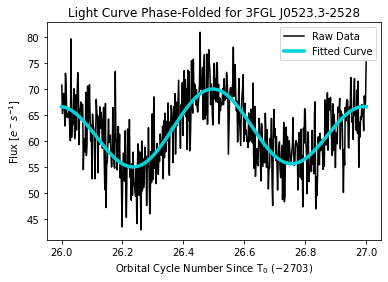

Cycle Number: 28 

Fitted parameters: A=2.1009888174771025, B=0.6880540676928796, C=-3.1415925508417, D=6.036024821294572, E=-1.2520916181155348, F=61.95828332463613

Reduced χ2: 0.8424616980226824 



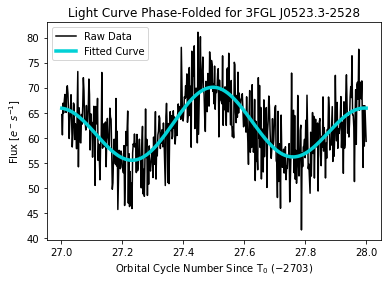

Cycle Number: 29 

Fitted parameters: A=1.7268348496207229, B=0.6881684379410844, C=-0.7897632696418251, D=6.853615999808406, E=3.14159264753216, F=61.864531379773794

Reduced χ2: 0.8836813082416112 



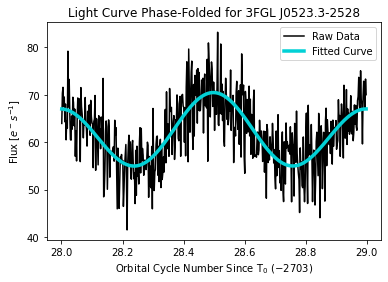

Cycle Number: 30 

Fitted parameters: A=2.077224093441382, B=0.68816903021181, C=-0.7575073145329805, D=6.149808967590339, E=3.141588268933073, F=61.85156362627618

Reduced χ2: 0.792663343006258 



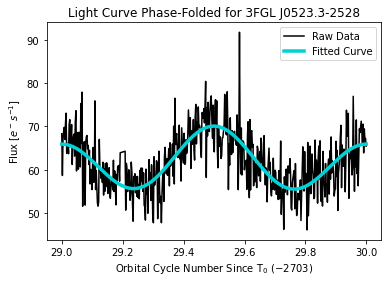

Cycle Number: 31 

Fitted parameters: A=1.5294135612179816, B=0.6880490942849214, C=-3.141590903750861, D=6.987000282852499, E=-1.3834764494902656, F=61.96164597974448

Reduced χ2: 0.8895475386455571 



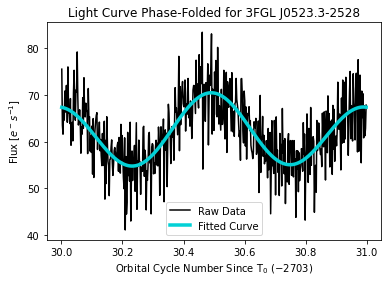

Cycle Number: 32 

Fitted parameters: A=1.7265877541917942, B=0.6881681723678932, C=-1.0364198310183919, D=7.3770493275163505, E=3.141590495391074, F=61.68924500099146

Reduced χ2: 0.7899543491168493 



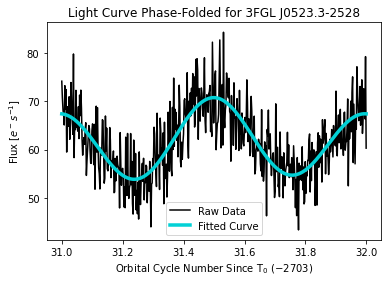

Cycle Number: 33 

Fitted parameters: A=1.465417469023116, B=0.6881674278011684, C=-1.2536805646981386, D=6.566384876324984, E=3.1403943264998038, F=61.750238940585696

Reduced χ2: 0.8817395076359098 



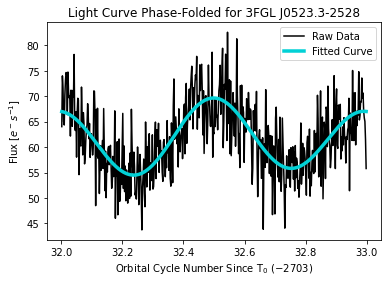

Cycle Number: 34 

Fitted parameters: A=1.7477615666852027, B=0.6880858262916743, C=3.141592653589518, D=6.4950071425108185, E=-0.07856197559696818, F=62.12626437861832

Reduced χ2: 0.9385069466960028 



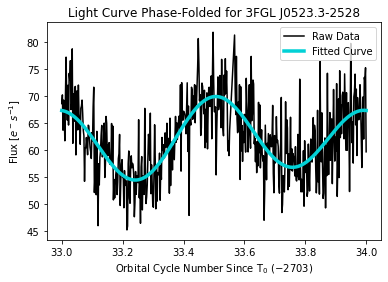

Cycle Number: 35 

Fitted parameters: A=1.731374503575844, B=0.6881663964069721, C=-0.9338145167992732, D=6.734097578327805, E=3.141592498335058, F=62.39106373630756

Reduced χ2: 0.7554398824132748 



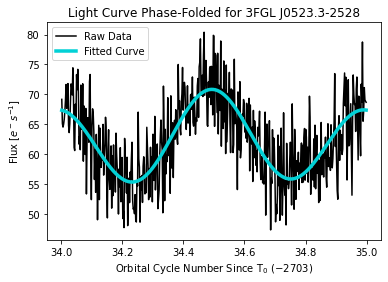

Cycle Number: 36 

Fitted parameters: A=1.7611624042821294, B=0.688059659133015, C=-3.1415883979738926, D=6.901176578686902, E=-1.0371259606302583, F=62.06101534154516

Reduced χ2: 0.8686727647244478 



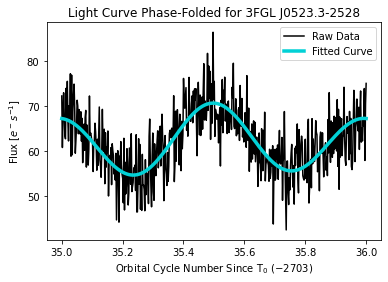

Cycle Number: 37 

Fitted parameters: A=1.8772893391392418, B=0.6881671936262737, C=-1.0182054465666224, D=7.048824366798817, E=3.1415824820244858, F=62.240759446488276

Reduced χ2: 0.894133379532494 



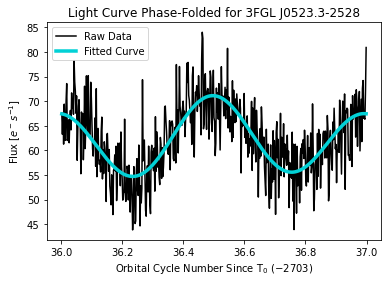

Cycle Number: 38 

Fitted parameters: A=2.0532388071570598, B=0.6881654394612795, C=-0.7761365286992573, D=5.959064418575598, E=3.141577063624395, F=62.29401648962301

Reduced χ2: 0.7143252302837881 



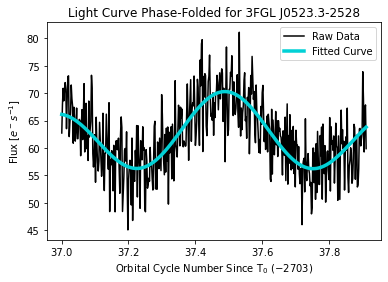

In [299]:
#Defining the test function
def test_func(x, A, B, C, D, E, F):
    return (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# Initial Values
A = 4 
B = P
C = 1 
D = 16 
E = 1 
F = averageflux 

init_vals = [A,B,C,D,E,F]

# Creates an array to store the reduced chi square values
reduced_chi_squared = []

phase = ((nan_tidied_time - T0_alt) / P) 

# Loops through each orbital cycle available in the data
for cycle in range(n_cycles):
    # Try and Except present as precaution for any data section that optimize.curve_fit can't find optimal parameters for
    try:
        # Selects section of data to analyse
        start = T0_alt + cycle*P
        end = T0_alt + (cycle + 1)*P
        mask = (nan_tidied_time >= start) & (nan_tidied_time < end)
        
        #Creates the arrays for this phase from our nan_tidied data (s_ stands for section)
        s_nan_tidied_time = nan_tidied_time[mask]
        s_nan_tidied_flux = nan_tidied_flux[mask]   
        s_nan_tidied_errors = nan_tidied_errors[mask]
        phase_cycle = phase[mask]                                 
    
        #Uses our test function with scipy's optimize.curve_fit to create a model for this orbital cycle
        params, params_covariance = optimize.curve_fit(test_func, s_nan_tidied_time, s_nan_tidied_flux, init_vals, s_nan_tidied_errors,maxfev=10000, bounds = ([0,0,-np.pi,0,-np.pi,0],[np.inf,np.inf,np.pi,np.inf,np.pi,np.inf]) )
        s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit = params
        

        #Prints out the cycle number (since T0_alt) and the fit parameters 
        print("Cycle Number:",cycle+1,"\n")
        print(f"Fitted parameters: A={s_A_fit}, B={s_B_fit}, C={s_C_fit}, D={s_D_fit}, E={s_E_fit}, F={s_F_fit}\n")
    
        #Creates an array for the test model
        y_fit = test_func(s_nan_tidied_time, s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit)
        
        #Finds the reduced chi**2 of the model
        r_chi_squared = (np.sum(((s_nan_tidied_flux-y_fit)/(s_nan_tidied_errors))**2))/(len(y_fit)-num_params)
        reduced_chi_squared = np.append(reduced_chi_squared, r_chi_squared)
        print("Reduced \u03C72:",r_chi_squared,"\n")
        
        
        #Plots the time vs flux of the real data, and the time vs the model data
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.plot(phase_cycle, y_fit, label="Fitted Curve", color='#02D1D6', lw=3.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title("Light Curve Phase-Folded for " + str(system_name))
        plt.legend()
        plt.show()
        
        
    except:
        # Except case for any optimize.curve_fit that can't find optimal parameters 
        print("Cycle Number:",cycle+1,"\n")
        print("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number:",cycle+1,"\n")

        # Keeps r_c_s array the same length as array it will be plot with 
        reduced_chi_squared = np.append(reduced_chi_squared, 0)
        
        # Plots the real data for the phase        
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.title("Raw Data with NO fit")
        plt.legend()
        plt.show()


This one also plots each of the harmonics separately if you want a more in depth look at whats happening.

Phase Number: 1 

Fitted parameters: A=73.39295862986874, B=0.6881437343458848, C=2.6935409731460895, D=23.89942337920572, E=0.8780922328623737, F=6.541628775072881

Reduced χ2: 0.8129162805978422 



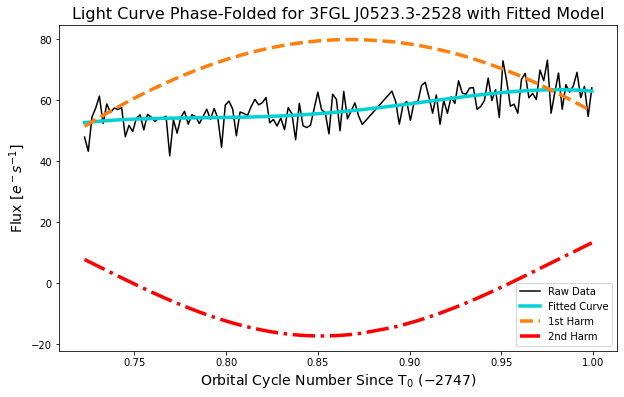

Phase Number: 2 

Fitted parameters: A=1.9108070029742685, B=0.6882485007354756, C=0.4454350329312157, D=6.816506005337485, E=6.283184585944672, F=58.97215692562523

Reduced χ2: 0.8718467041151856 



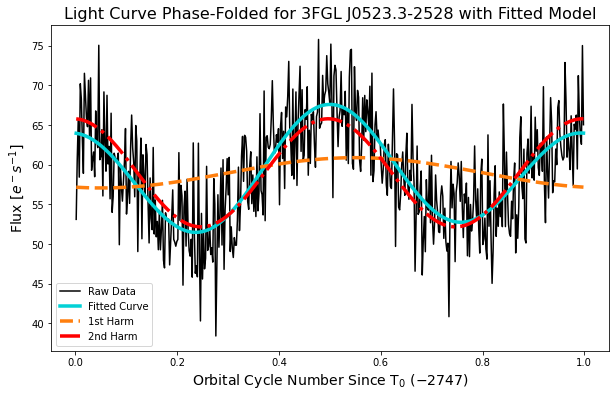

Phase Number: 3 

Fitted parameters: A=2.0282861634083194, B=0.6882478993703282, C=0.5759926327034739, D=6.9157954977064655, E=6.281012043162396, F=58.68073715881967

Reduced χ2: 0.9965486196643039 



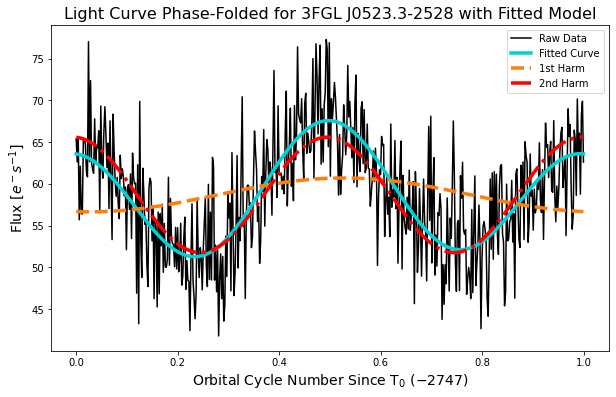

Phase Number: 4 

Fitted parameters: A=1.8704362217183954, B=0.688246170825773, C=0.38239287082296153, D=6.229097457833503, E=6.283185306076874, F=58.86987666514116

Reduced χ2: 0.8350931905987704 



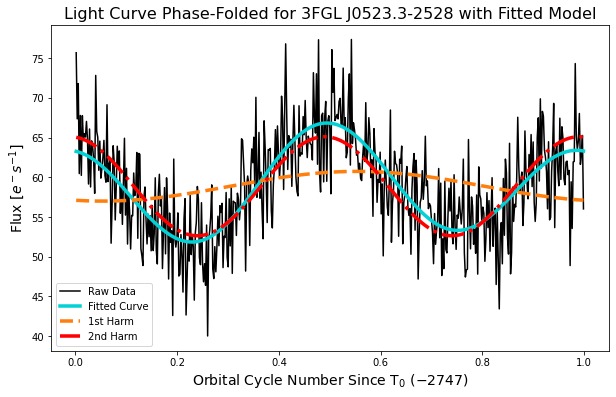

Phase Number: 5 

Fitted parameters: A=1.9487219029665117, B=0.6882500416050168, C=0.5353474757868458, D=6.53320755932761, E=6.283185298438248, F=58.685939991629894

Reduced χ2: 1.0998426189754207 



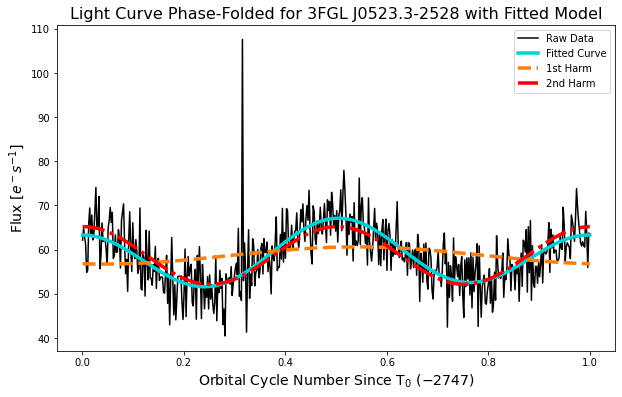

Phase Number: 6 

Fitted parameters: A=1.7823177393935314, B=0.6882490179344188, C=0.21583892767747143, D=7.11085038689723, E=6.283133493346352, F=58.633623618446556

Reduced χ2: 0.8887011669195203 



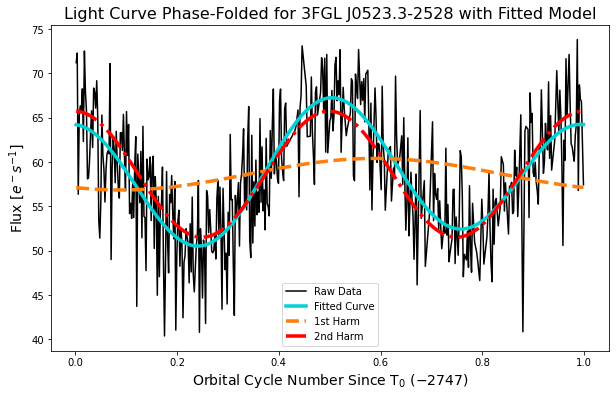

Phase Number: 7 

Fitted parameters: A=2.33109185099901, B=0.6882496069860651, C=0.5782590144690937, D=6.65785269880706, E=6.283185303549265, F=58.13685248221013

Reduced χ2: 0.8564957228800335 



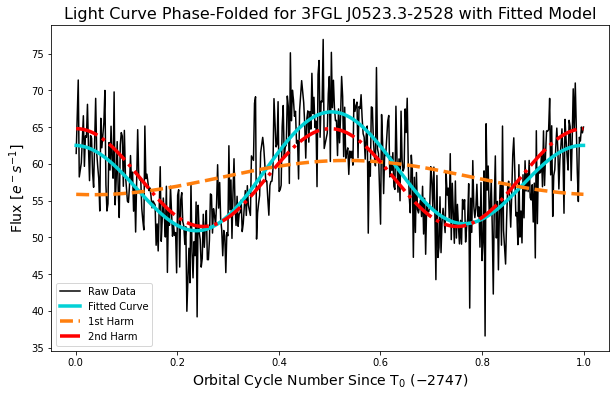

Phase Number: 8 

Fitted parameters: A=2.2240500236594576, B=0.6882068174990428, C=3.790162667092856e-11, D=7.463217048665117, E=4.7018437423114765, F=58.715941378139675

Reduced χ2: 0.8212774542584399 



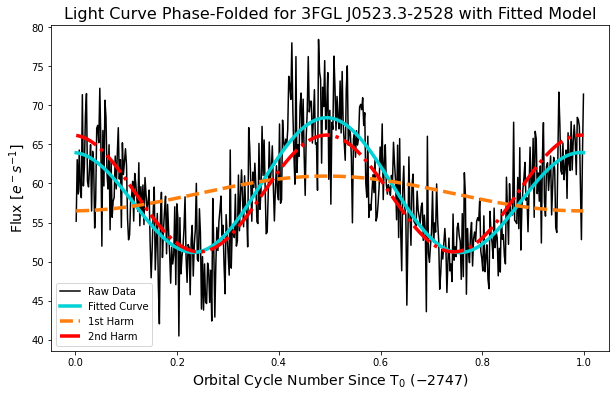

Phase Number: 9 

Fitted parameters: A=1.259536891211281, B=0.6882466871992536, C=0.4424859295549505, D=6.459340473174223, E=6.283178359325071, F=58.7239999335121

Reduced χ2: 0.9414233911629905 



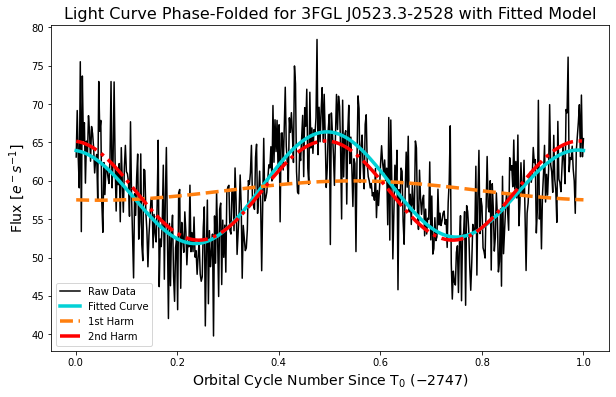

Phase Number: 10 

Fitted parameters: A=2.2298252610817912, B=0.6882462385608887, C=0.3185769491990594, D=6.2055585953259005, E=6.28024755715249, F=58.78744059545187

Reduced χ2: 0.8746770845511179 



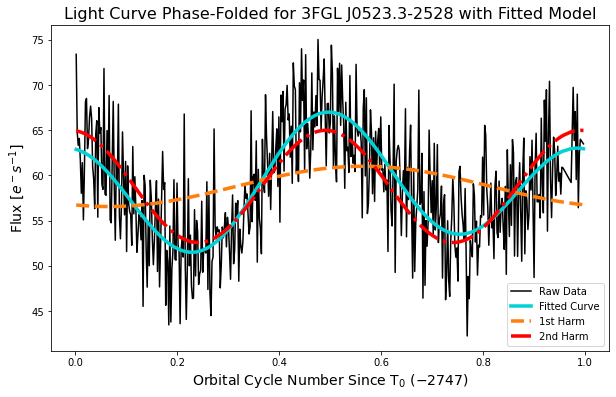

Phase Number: 11 

Fitted parameters: A=2.1549071649171228, B=0.6882473691781987, C=0.4177430900572655, D=6.719378974241836, E=6.27169254957756, F=58.62620382222762

Reduced χ2: 0.9141826496527976 



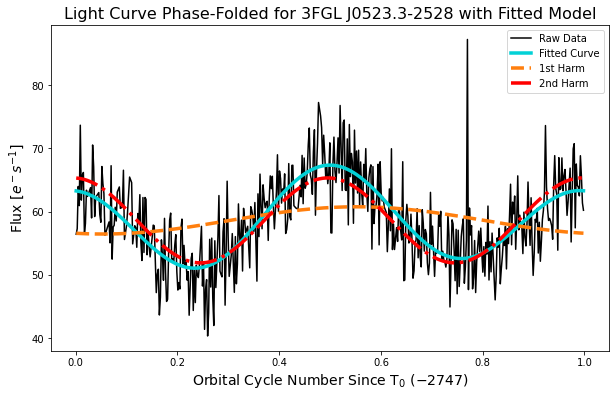

Phase Number: 12 

Fitted parameters: A=2.472733279270653, B=0.6882478106229689, C=0.41028324630927104, D=6.437971045576958, E=6.283185254891534, F=59.36571511671434

Reduced χ2: 0.8674915675201361 



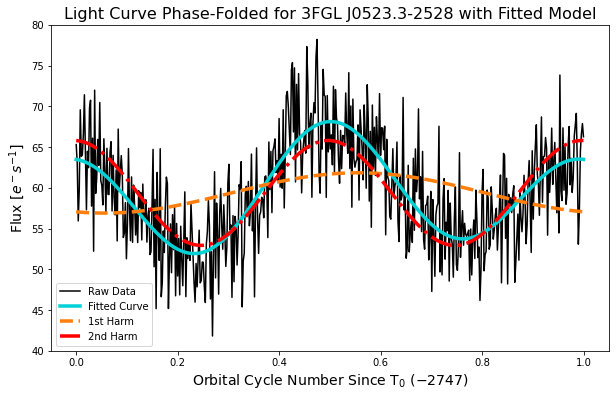

Phase Number: 13 

Fitted parameters: A=1.7667508088512671, B=0.6882475807156014, C=0.6922587003573055, D=7.3607860068888264, E=6.28316837657054, F=59.75178539797997

Reduced χ2: 0.8591974903890574 



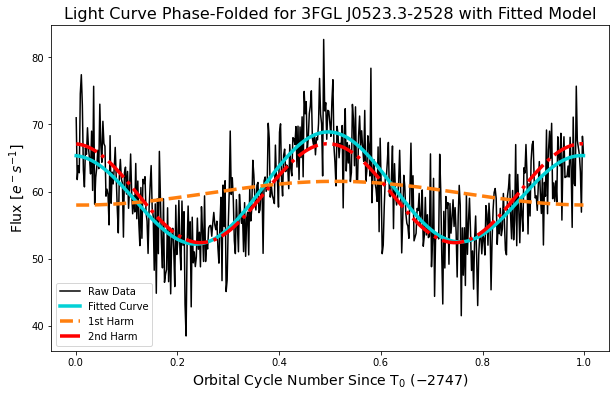

Phase Number: 14 

Fitted parameters: A=14.104670277222883, B=0.6881417407173473, C=0.3365605173082982, D=11.28228448019044, E=2.2709954670515873, F=48.93186689056957

Reduced χ2: 0.77632952393197 



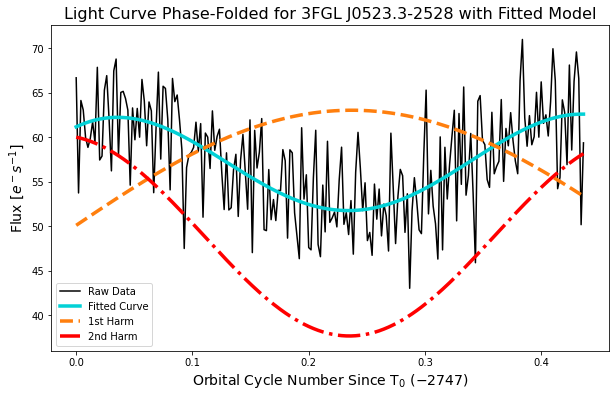

Phase Number: 15 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number: 15 



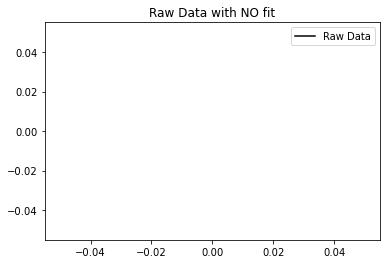

Phase Number: 16 

Fitted parameters: A=3.50176780744112, B=0.6882422152517383, C=1.4454215650753452, D=5.396571097207848, E=6.283185275801106, F=60.064185428242304

Reduced χ2: 0.7141196112477818 



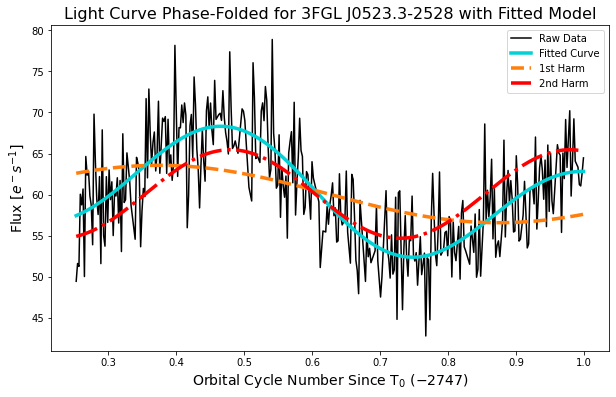

Phase Number: 17 

Fitted parameters: A=2.1851687677179306, B=0.6882217979373916, C=2.1007244318450605e-06, D=6.229937690014116, E=5.333235232461597, F=58.794737663327815

Reduced χ2: 0.873217958888138 



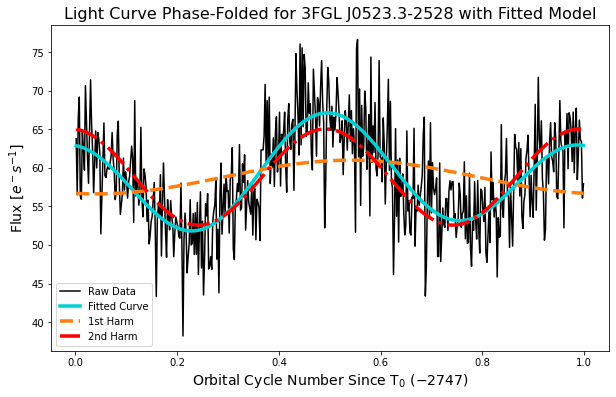

Phase Number: 18 

Fitted parameters: A=1.8902303699739156, B=0.6882239224858887, C=3.5155279294983023e-06, D=6.6556103799538695, E=5.330029895202943, F=58.155626985285714

Reduced χ2: 0.8672306326265833 



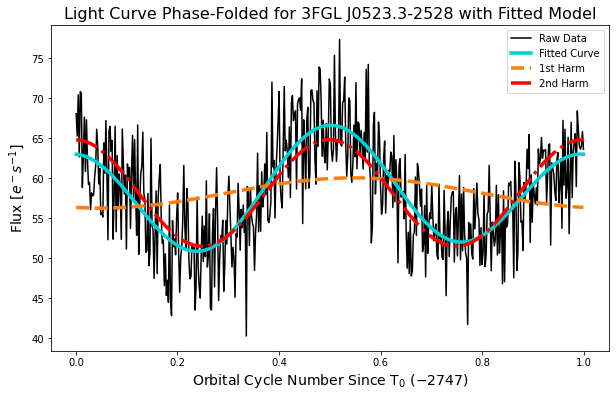

Phase Number: 19 

Fitted parameters: A=1.8388535793590837, B=0.6882477372607035, C=0.9469443931553956, D=6.341583907276941, E=6.283176660648449, F=58.00396027576677

Reduced χ2: 0.8397735809137498 



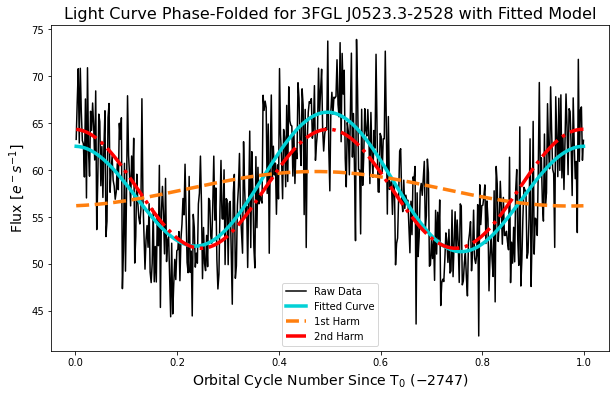

Phase Number: 20 

Fitted parameters: A=2.1497747950095674, B=0.6882220739729588, C=1.6380902827272444e-07, D=6.4228253144466665, E=5.297541985075769, F=58.58909096869239

Reduced χ2: 0.8341231939038353 



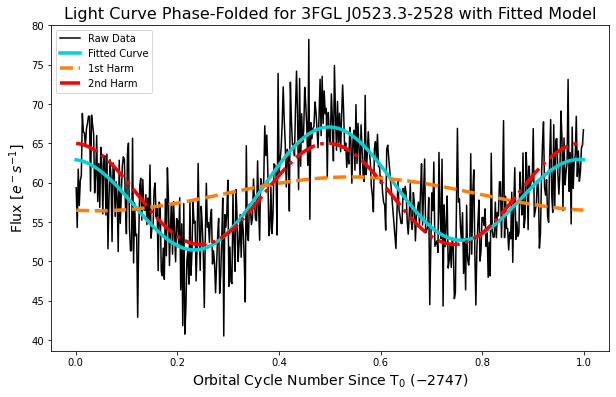

Phase Number: 21 

Fitted parameters: A=2.5046973483988175, B=0.6882473364356497, C=0.5791589273159784, D=6.4637475091377805, E=6.280612411387049, F=58.54896208224502

Reduced χ2: 0.8120074925125128 



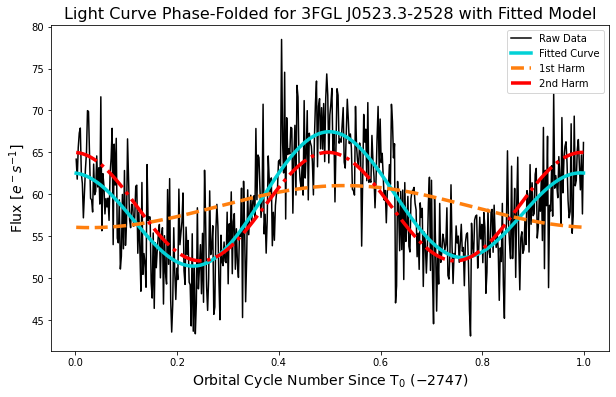

Phase Number: 22 

Fitted parameters: A=2.0185571946121708, B=0.6882170509263688, C=2.1291884142729187e-08, D=6.70894888719136, E=5.070945416895488, F=59.02236769774983

Reduced χ2: 0.9121053461524793 



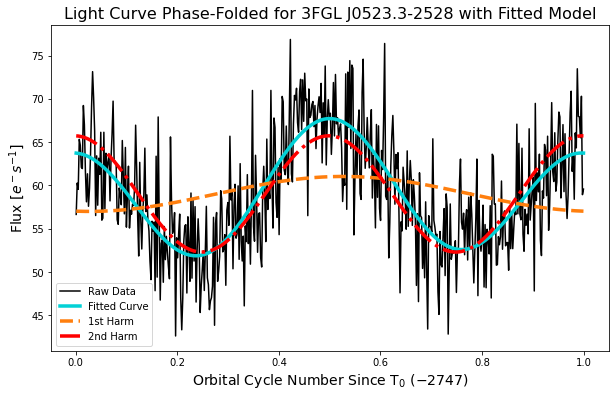

Phase Number: 23 

Fitted parameters: A=2.3661002404254265, B=0.6881762449008872, C=2.7634825160239196e-05, D=6.8943229394245, E=3.3851199492151762, F=58.871496852759044

Reduced χ2: 0.8977226399436863 



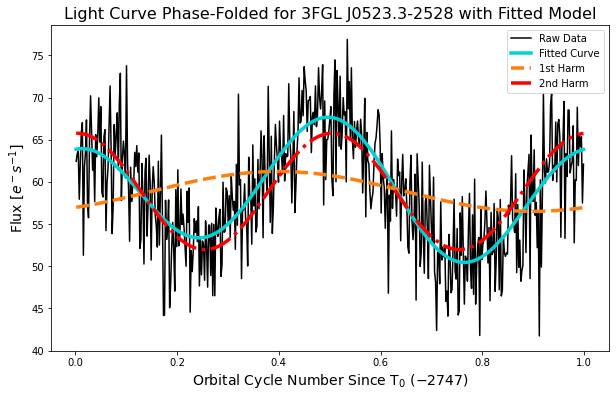

Phase Number: 24 

Fitted parameters: A=1.5854184633005939, B=0.6882485923992145, C=0.8726841144039964, D=6.977979338293679, E=6.283169777175367, F=58.65729684734868

Reduced χ2: 0.8600082753485662 



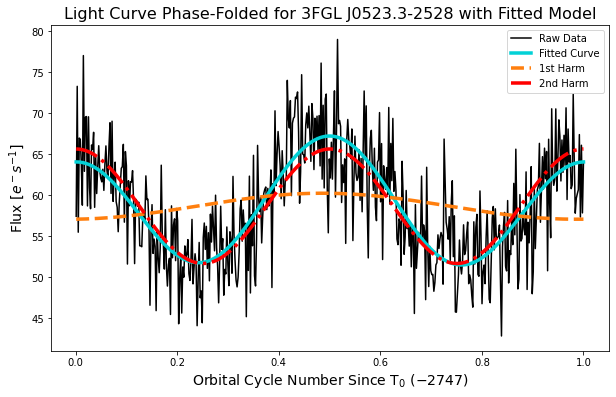

Phase Number: 25 

Fitted parameters: A=2.0484144850870654, B=0.6882453168112299, C=0.8746869966371655, D=6.789161537294447, E=6.283177555012415, F=58.68700601783277

Reduced χ2: 0.7499405643621913 



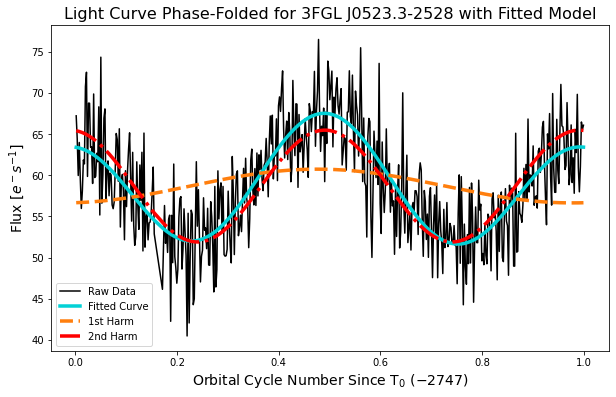

Phase Number: 26 

Fitted parameters: A=1.5327789557990712, B=0.6882471131764923, C=0.8604704309584323, D=6.435784235885563, E=6.28315565455798, F=58.672427259484195

Reduced χ2: 0.9043398962517399 



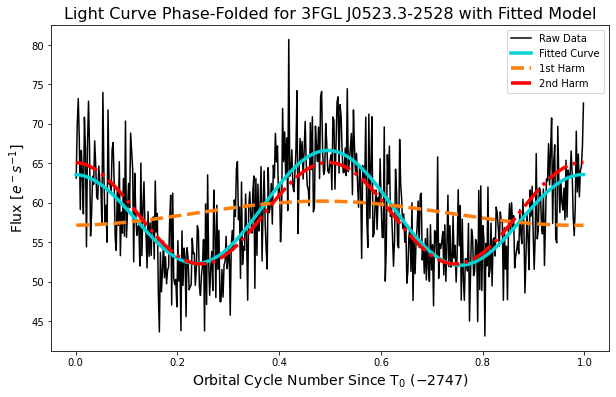

Phase Number: 27 

Fitted parameters: A=1.8878639006456257, B=0.6882472252841328, C=0.9089410866107882, D=7.314634192558759, E=6.2831790504124685, F=59.08868048439579

Reduced χ2: 0.8610528977759888 



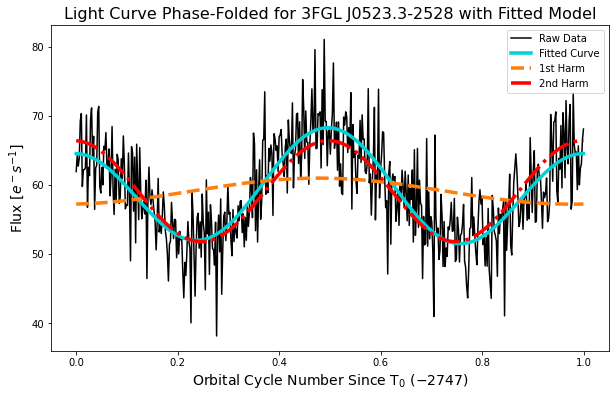

Phase Number: 28 

Fitted parameters: A=1.8285329331708857, B=0.6882451340152187, C=0.5700067145702795, D=6.736325069198677, E=6.283171153886087, F=58.66855759655133

Reduced χ2: 0.8778379392151487 



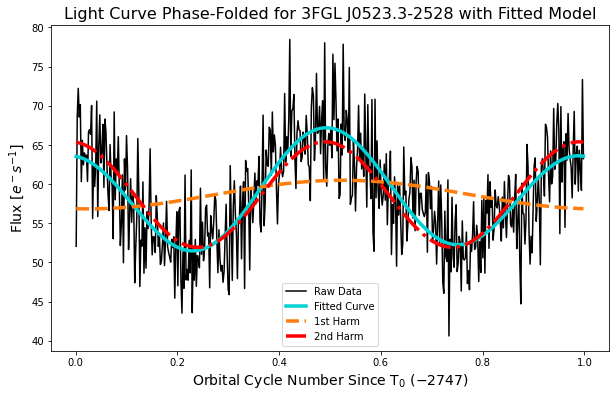

Phase Number: 29 

Fitted parameters: A=1.590651406992275, B=0.6882471621537577, C=0.749407829052294, D=6.98245037345544, E=6.283152961865464, F=58.775247406790626

Reduced χ2: 0.8115203380923727 



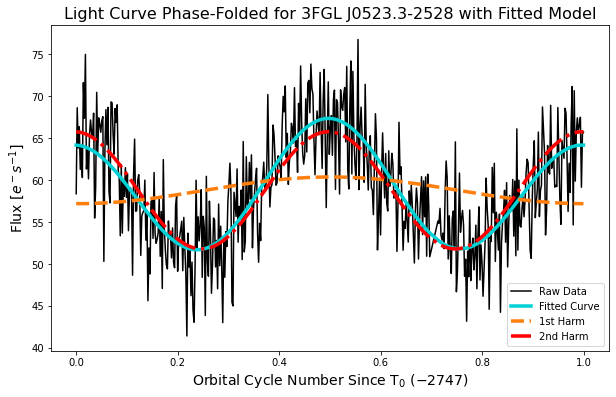

Phase Number: 30 

Fitted parameters: A=2.031649341982599, B=0.6882461938847672, C=0.9285244609381867, D=6.345024387586792, E=6.283159593344675, F=59.14457504419818

Reduced χ2: 0.9224066609761999 



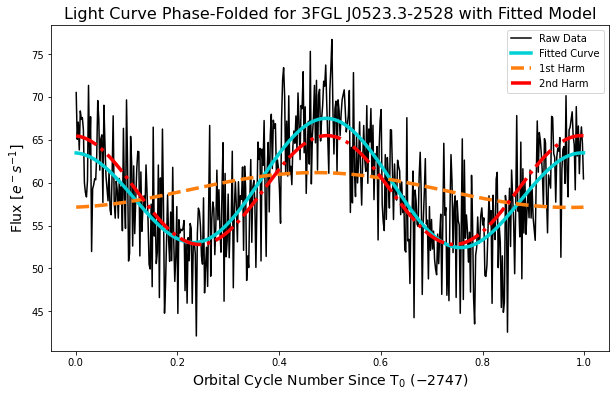

Phase Number: 31 

Fitted parameters: A=1.9628046572725564, B=0.6881860768776242, C=4.095751663130685e-06, D=6.209353032288263, E=3.889201706239075, F=59.194730967711656

Reduced χ2: 0.8969933894626891 



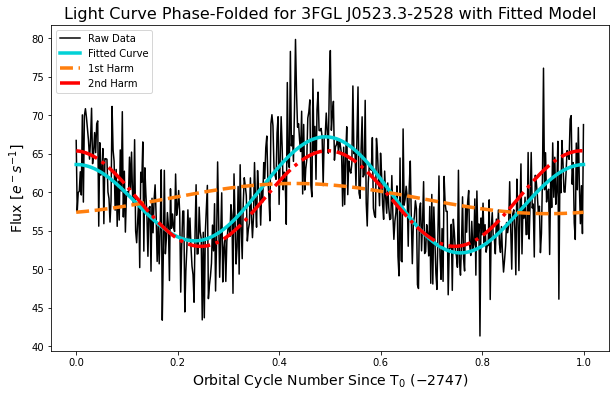

Phase Number: 32 

Fitted parameters: A=1.458841006434856, B=0.688245777776221, C=0.9996732861750546, D=7.119679510017992, E=6.283156345132177, F=58.8663386147002

Reduced χ2: 0.8521261668103266 



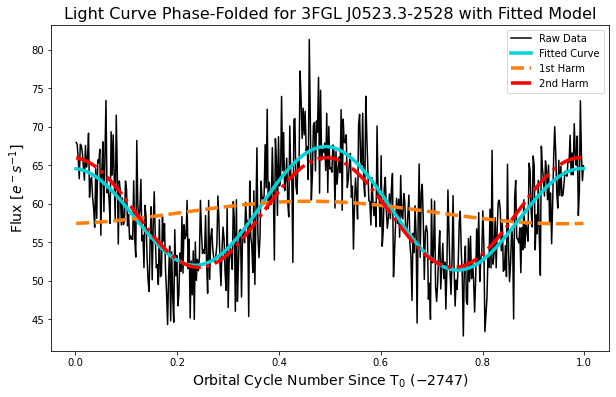

In [311]:
# Finds the number of phase cycles available from the tidied data 
n_cycles = int(((nan_tidied_time[-1]) - (nan_tidied_time[0])) / P) + 1

#Defining the test function
def test_func(x, A, B, C, D, E, F):
    return (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# First harmonic
def test_func_1(x, A, B, C, F):
    return (A * np.sin(2*np.pi/B * x + C)) + F

# Second harmonic
def test_func_2(x, B, D, E, F):
    return (D * np.sin(4*np.pi/B * x + E)) + F

A = 4 
B = P
C = 1 
D = 16 
E = 1 
F = averageflux 

init_vals = [A,B,C,D,E,F]

# Creates an array to store the reduced chi square values
reduced_chi_squared = []


# Creates a custom color map for the heatmap (pcolormesh). I found values for the colours of ["blue near black","mid range blue","blue near white"]
custom_cmap = LinearSegmentedColormap.from_list("custom", ["#011B31", "#058CFB", "#DDF0FF"])


# Loops through each phase cycle available in the data
for cycle in range(n_cycles):
    # Try and Except present as precaution for any data section that optimize.curve_fit can't find optimal parameters for
    try:
        # Selects section of data (the phase) to analyse
        start = T0_alt + cycle*P
        end = T0_alt + (cycle + 1)*P
        mask = (nan_tidied_time >= start) & (nan_tidied_time < end)
        
        #Creates the arrays for this phase from our nan_tidied data (s_ stands for section)
        s_nan_tidied_time = nan_tidied_time[mask]
        s_nan_tidied_flux = nan_tidied_flux[mask]   
        s_nan_tidied_errors = nan_tidied_errors[mask]
        phase_cycle = phase[mask]                                 
    
        #Uses our test function with scipy's optimize.curve_fit to create a model for this phase
        params, params_covariance = optimize.curve_fit(test_func, s_nan_tidied_time, s_nan_tidied_flux, init_vals, s_nan_tidied_errors,maxfev=10000, bounds = ([0,0,0,0,0,0],[np.inf,np.inf,2*np.pi,np.inf,2*np.pi,np.inf]) )
        s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit = params
        

        #Prints out the phase number (since T0_alt) and the fit parameters 
        print("Phase Number:",cycle+1,"\n")
        print(f"Fitted parameters: A={s_A_fit}, B={s_B_fit}, C={s_C_fit}, D={s_D_fit}, E={s_E_fit}, F={s_F_fit}\n")
    
        #Creates an array for the test model
        y_fit = test_func(s_nan_tidied_time, s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit)
        y_fit_1 = test_func_1(s_nan_tidied_time, s_A_fit, s_B_fit, s_C_fit,s_F_fit)
        y_fit_2 = test_func_2(s_nan_tidied_time, s_B_fit, s_D_fit, s_E_fit, s_F_fit)
        
        #Finds the reduced chi**2 of the model
        r_chi_squared = (np.sum(((s_nan_tidied_flux-y_fit)/(s_nan_tidied_errors))**2))/(len(y_fit)-num_params)
        reduced_chi_squared = np.append(reduced_chi_squared, r_chi_squared)
        print("Reduced \u03C72:",r_chi_squared,"\n")
        
        #Plots the time vs flux of the real data, and the time vs the model data
        plt.figure(figsize=(10, 6))
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.plot(phase_cycle, y_fit, label="Fitted Curve", color='#02D1D6', lw=3.5)
        plt.plot(phase_cycle, y_fit_1,'C1--', label="1st Harm", lw=3.5)
        plt.plot(phase_cycle, y_fit_2,'r-.', label="2nd Harm", lw=3.5)
        plt.xlabel(xlabel, size=14)
        plt.ylabel(ylabel, size=14)
        plt.title("Light Curve Phase-Folded for " + str(system_name) + " with Fitted Model", size=16)
        plt.legend()
        plt.show()
        
        

    except:
        # Except case for any optimize.curve_fit that can't find optimal parameters 
        print("Phase Number:",cycle+1,"\n")
        print("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number:",cycle+1,"\n")

        # Keeps r_c_s array the same length as array it will be plot with 
        reduced_chi_squared = np.append(reduced_chi_squared, 0)
        
        # Plots the real data for the phase        
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.title("Raw Data with NO fit")
        plt.legend()
        plt.show()


#### Creating arrays for future plot analysis:

In [312]:
# This cell does similar to the one above in terms of its looping, but instead of plotting it is now appending each of the
# fit parameters and the phase number to the arrays defined for them for future plotting and analysis
init_vals = [A,B,C,D,E,F]

A_params = []
B_params = []
C_params = []
D_params = []
E_params = []
F_params = []
A_cov_params = []
B_cov_params = []
C_cov_params = []
D_cov_params = []
E_cov_params = []
F_cov_params = []
Cycle_Number = []

# Loops through each phase cycle available in the data
for cycle in range(n_cycles):
    # Try and Except present as precaution for any data section that optimize.curve_fit can't find optimal parameters for
    try:
        # Selects section of data (the phase) to analyse
        start = T0_alt + cycle*P
        end = T0_alt + (cycle + 1)*P
        mask = (nan_tidied_time >= start) & (nan_tidied_time < end)
        
        #Creates the arrays for this phase from our nan_tidied data (s_ stands for section)
        s_nan_tidied_time = nan_tidied_time[mask]
        s_nan_tidied_flux = nan_tidied_flux[mask]   
        s_nan_tidied_errors = nan_tidied_errors[mask]
    
        #Uses our test function with scipy's optimise.curve_fit to create a model for this phase
        params, params_covariance = optimize.curve_fit(test_func, s_nan_tidied_time, s_nan_tidied_flux, init_vals, s_nan_tidied_errors,maxfev=10000, bounds = ([0,0,0,0,0,0],[np.inf,np.inf,2*np.pi,np.inf,2*np.pi,np.inf]) ) 
        s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit = params
        s_A_cov, s_B_cov, s_C_cov, s_D_cov, s_E_cov, s_F_cov = params_covariance
        
        
        A_params = np.append(A_params, s_A_fit)
        B_params = np.append(B_params, s_B_fit)
        C_params = np.append(C_params, s_C_fit)
        D_params = np.append(D_params, s_D_fit)
        E_params = np.append(E_params, s_E_fit)
        F_params = np.append(F_params, s_F_fit)
        A_cov_params = np.append(A_cov_params, s_A_cov[0])
        B_cov_params = np.append(B_cov_params, s_B_cov[1])
        C_cov_params = np.append(C_cov_params, s_C_cov[2])
        D_cov_params = np.append(D_cov_params, s_D_cov[3])
        E_cov_params = np.append(E_cov_params, s_E_cov[4])
        F_cov_params = np.append(F_cov_params, s_F_cov[5])
        Cycle_Number = np.append(Cycle_Number, cycle+1)
        
    except:
        A_params = np.append(A_params, 0)
        B_params = np.append(B_params, 0)
        C_params = np.append(C_params, 0)
        D_params = np.append(D_params, 0)
        E_params = np.append(E_params, 0)
        F_params = np.append(F_params, 0)
        A_cov_params = np.append(A_cov_params, 0)
        B_cov_params = np.append(B_cov_params, 0)
        C_cov_params = np.append(C_cov_params, 0)
        D_cov_params = np.append(D_cov_params, 0)
        E_cov_params = np.append(E_cov_params, 0)
        F_cov_params = np.append(F_cov_params, 0)        
        Cycle_Number = np.append(Cycle_Number, cycle+1)


#### Plots of each fit parameter (and the reduced chi squared values) versus orbital cycle number:

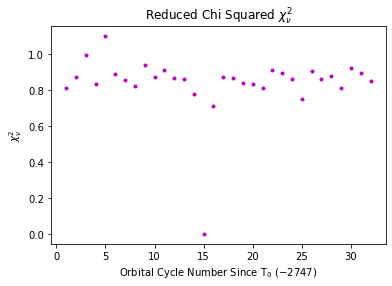

Mean Value for Reduced Chi Squared: 0.8407046890531742


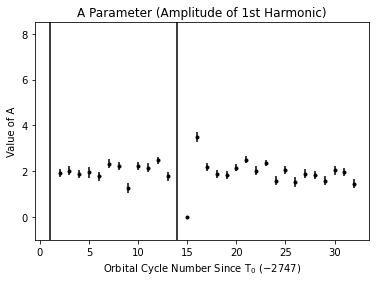

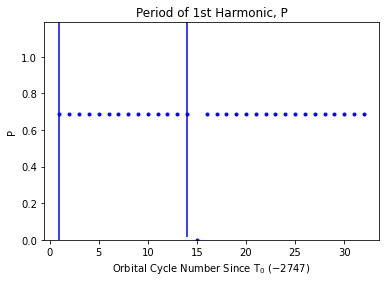

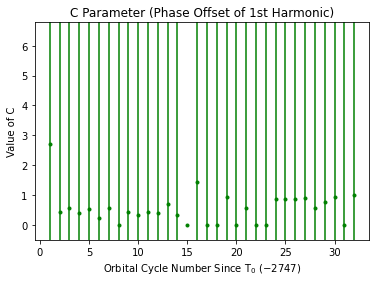

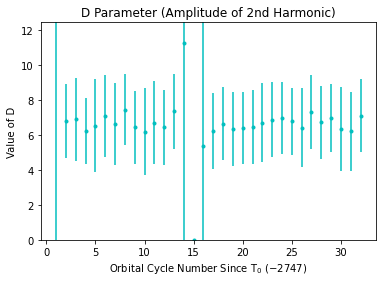

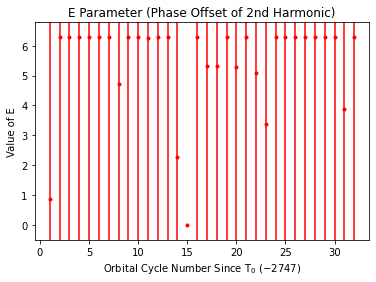

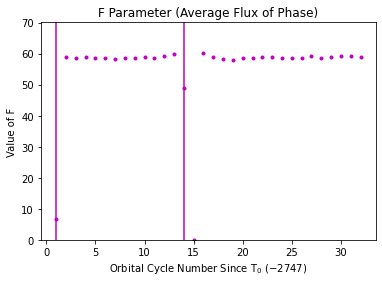

In [313]:
# This cell plots: * The reduced chi squared values of each phase
#                  * The fit parameters of each phase, all on separate plots.

plt.plot(Cycle_Number, reduced_chi_squared, color='m',marker='.',linestyle='')
plt.title(r"Reduced Chi Squared $\chi_\nu^2$")
plt.ylabel(r"$\chi_\nu^2$")
plt.xlabel(xlabel)
plt.show()

print("Mean Value for Reduced Chi Squared:",np.mean(reduced_chi_squared))


# Some parameter's errors contain very large values, so these ones have filters to create new limit arrays to constrain
# what values are visible in the plot (we don't need to look at the very large errors because these are for
# incomplete phase data sections)

# Creating arrays for y-axis limits
A_limits = []
B_limits = []
D_limits = []
F_limits = []


# Any values with an error value > 5 is cut off of the plot. This was done for A,B,D, and F. The limits for C and E, the phase offsets is more straightforward due to them being constarined to [0,2pi]
for i in range(len(A_cov_params)):
    if A_cov_params[i] < 5:
        A_limits = np.append(A_limits, A_params[i])
        
plt.errorbar(Cycle_Number, A_params, yerr=A_cov_params, fmt='k.', ecolor='k')
plt.ylim(-1, np.max(A_limits) + 5)
plt.ylabel("Value of A")
plt.xlabel(xlabel)
plt.title("A Parameter (Amplitude of 1st Harmonic)")
plt.show()

for i in range(len(B_cov_params)):
    if B_cov_params[i] < 5:
        B_limits = np.append(B_limits, B_params[i])

plt.errorbar(Cycle_Number, B_params, yerr=B_cov_params, fmt='b.', ecolor='b')
plt.ylim(0, np.max(B_limits) + 0.5)
plt.ylabel("P")
plt.xlabel(xlabel)
plt.title("Period of 1st Harmonic, P")
plt.show()


plt.errorbar(Cycle_Number, C_params, yerr=C_cov_params, fmt='g.', ecolor='g') 
plt.ylim(- 0.5,2*np.pi + 0.5)
plt.ylabel("Value of C")
plt.xlabel(xlabel)
plt.title("C Parameter (Phase Offset of 1st Harmonic)")
plt.show()


for i in range(len(D_cov_params)):
    if D_cov_params[i] < 5:
        D_limits = np.append(D_limits, D_params[i])
        
plt.errorbar(Cycle_Number, D_params, yerr=D_cov_params, fmt='c.', ecolor='c') 
plt.ylim(0, np.max(D_limits) + 5)
plt.ylabel("Value of D")
plt.xlabel(xlabel)
plt.title("D Parameter (Amplitude of 2nd Harmonic)")
plt.show()

plt.errorbar(Cycle_Number, E_params, yerr=E_cov_params, fmt='r.', ecolor='r')
plt.ylim(- 0.5,2*np.pi + 0.5)
plt.ylabel("Value of E")
plt.xlabel(xlabel)
plt.title("E Parameter (Phase Offset of 2nd Harmonic)")
plt.show()

for i in range(len(F_cov_params)):
    if F_cov_params[i] < 5:
        F_limits = np.append(F_limits, F_params[i])

plt.errorbar(Cycle_Number, F_params, yerr=F_cov_params, fmt='m.', ecolor='m')
plt.ylim(0, np.max(F_limits) + 10)
plt.ylabel("Value of F")
plt.xlabel(xlabel)
plt.title("F Parameter (Average Flux of Phase)")
plt.show()

## Analysing the fit parameters more closely

If any periodic pattern is noticed in the $A_1$ parameters in the graph above, then the below analysis can be done to test for star spots.

The cell below will plot the A1 and $\phi_1$ parameters, fitting a sine model to the $A_1$ parameters, and allowing a closer look at the behaviour of $\phi_1$. It automatically excludes any values where the error in $A_1$ was > 5 *and* any remaining values greater than 2 times the mean of what remained.

Fitted parameters for sine curve: A=0.26998986059174657, B=4.627000763574654, C=4.693823382396492, D=1.9968976914249232 



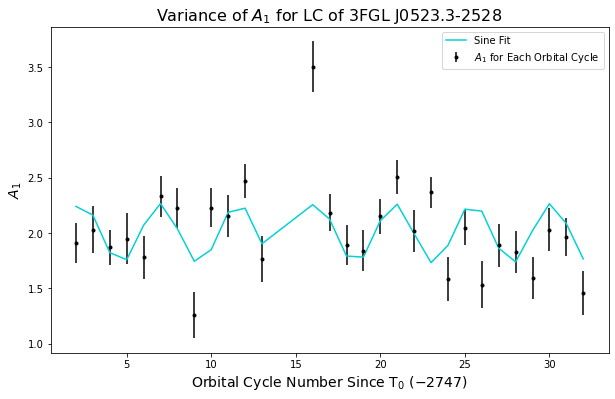

4.225354586488195


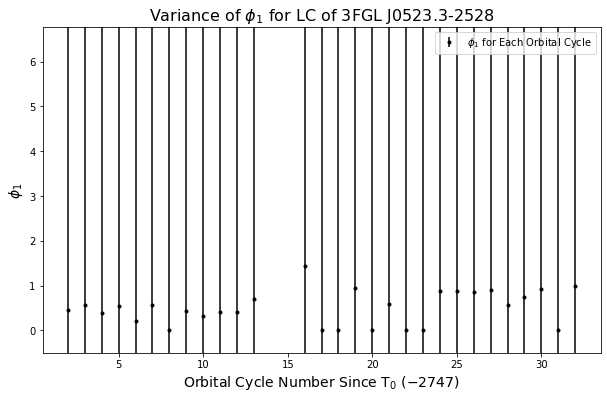

In [314]:
A_params_new = []
A_params_new_mid = []
A_cov_params_new = []

Cycle_number_new = []

C_params_new = []
C_params_new_mid = []
C_cov_params_new = []

# Removes any values from each array where the error of A1 is 0 or greater than 5 
for i in range(len(A_cov_params)):
    if (0 < A_cov_params[i] <= 5):
        A_cov_params_new = np.append(A_cov_params_new, A_cov_params[i])
        Cycle_number_new = np.append(Cycle_number_new, Cycle_Number[i])
        A_params_new_mid = np.append(A_params_new_mid, A_params[i])
        C_params_new_mid = np.append(C_params_new_mid, C_params[i])
        C_cov_params_new = np.append(C_cov_params_new, C_cov_params[i])

# Deals with any remaining values where the error was within the above window, but the value itself is an outlier > 2*mean
A_params_new = A_params_new_mid[A_params_new_mid < 2*np.mean(A_params_new_mid)]
Cycle_number_new = Cycle_number_new[A_params_new_mid < 2*np.mean(A_params_new_mid)]
A_cov_params_new = A_cov_params_new[A_params_new_mid < 2*np.mean(A_params_new_mid)]

C_params_new = C_params_new_mid[A_params_new_mid < 2*np.mean(A_params_new_mid)]
C_cov_params_new = C_cov_params_new[A_params_new_mid < 2*np.mean(A_params_new_mid)]

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

averageflux = np.mean(nan_tidied_flux)

A = np.mean(A_params_new)
B = 40
C = 1
D = np.mean(A_params_new)

init_vals = [A,B,C,D]

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, A_params_new, init_vals)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)


# Plots the A1 parameters with the sine fit model
plt.figure(figsize=(10, 6))
plt.plot(Cycle_number_new, y_fit, label="Sine Fit", color='#02D1D6')
plt.errorbar(Cycle_number_new, A_params_new, yerr=A_cov_params_new, fmt='k.', ecolor='k', label=r"$A_1$ for Each Orbital Cycle")
plt.title(r"Variance of $A_1$ for LC of " + str(system_name), size=16 )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel, size =14)
plt.ylabel(r"$A_1$", size=14)

plt.legend()
plt.show()

r_chi_squared = (np.sum(((A_params_new-y_fit)/(A_cov_params_new))**2))/(len(y_fit)-num_params)
print(r_chi_squared)

# Plots the C parameters 
plt.figure(figsize=(10, 6))
plt.errorbar(Cycle_number_new, C_params_new, yerr=C_cov_params_new, fmt='k.', ecolor='k', label=r"$\phi_1$ for Each Orbital Cycle")
plt.title(r"Variance of $\phi_1$ for LC of " + str(system_name), size=16 )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel, size =14)
plt.ylabel(r"$\phi_1$", size=14)
plt.ylim(- 0.5,2*np.pi + 0.5)


plt.legend()
plt.savefig("J0212Phi1.pdf")
plt.show()

Approximating the size of the spot. The result is a percentage of visible stellar surface covered by the spot.

Required inputs from user:

In [151]:
T_stellar = 6000    # Temperature of the main surface of the companion star [K]

T_spot = T_stellar - 500    # Temperature of the spot estimated to be 500 K less than T_stellar [5]

flux_peak_to_peak = 95     # This is a rough "by eye" guess of the overall flux peak to peak of the full lightcurve

In [152]:
A_spot_over_A_stellar = ( (2*A_fit)/flux_peak_to_peak ) / (1 - (T_spot/T_stellar)**4 )
print("The approximate spot coverage percentage of the stellar surface is: ", 100*A_spot_over_A_stellar)

The approximate spot coverage percentage of the stellar surface is:  8.384330013443472


Below here is the rougher manual process followed to obtain what we got from the automatic version above. This is left here to be followed in case the automatic version is not as robust as desired. There are also cells that will plot the desired parameter results for $A_1$, $A_2$, and $\phi_1$.

In [72]:
# Looking through the A1 parameters to see which ones we want to exclude from analysis
i=0
for i in range(len(A_params)):
    print(i, "=", A_params[i])
print("Errors")
for i in range(len(A_cov_params)):
    print(i, "=", A_cov_params[i])


0 = 9518.803220130434
1 = 1.8604666337078117
2 = 0.9423544582388674
3 = 1.2691159882748395
4 = 1.729439968385651
5 = 2.1069393822031435
6 = 1.67647317803297
7 = 1.994949986168543
8 = 1.8165559535458267
9 = 1.702939644285738
10 = 1.9003865446634691
11 = 0.9790665135982561
12 = 1.347141869031368
13 = 1.5509733615139876
14 = 1.3141266205177562
15 = 1.270107570509868
16 = 1.3090803841781629
17 = 1.6561102296894055
18 = 145.11324628845585
19 = 0.0
20 = 2.2494256410207836
21 = 1.4620725046527772
22 = 1.7234710280049836
23 = 1.6593335781713936
24 = 1.0626733667023633
25 = 1.6973047423567174
26 = 1.708637872681902
27 = 2.097479670716329
28 = 1.7247596051914396
29 = 2.0753144636964396
30 = 1.5252190970014916
31 = 1.7244115981115555
32 = 1.4635916422990838
33 = 1.7446286301869338
34 = 1.7293598057357729
35 = 1.7571304858528547
36 = 1.8752070083749572
37 = 2.051122526447657
ERRors
0 = 5010139082.789174
1 = 0.22403016697732595
2 = 0.30371751052713203
3 = 0.2028348291306198
4 = 0.17758174430710222


In [73]:
# Compared that to D (A2) to see if similar/ the same ith elements of the arrays would be excluded.
i=0
for i in range(len(D_params)):
    print(i, "=", D_params[i])
print("Errors")
for i in range(len(D_cov_params)):
    print(i, "=", D_cov_params[i])

0 = 2447.7707429853917
1 = 6.224048081754538
2 = 7.723062772033501
3 = 7.069493618323675
4 = 6.7284799943394455
5 = 7.29896167144304
6 = 6.285927007714861
7 = 6.859670684461153
8 = 6.766486406412532
9 = 7.148057127115802
10 = 7.067898531855836
11 = 6.774821303507771
12 = 6.2310609897386815
13 = 6.793492841243007
14 = 6.510124244306093
15 = 6.977340440004835
16 = 7.183928235458058
17 = 6.974555286091204
18 = 75.2162587625581
19 = 0.0
20 = 5.019558149050346
21 = 7.434137184864757
22 = 6.928155546995751
23 = 6.537790173703381
24 = 6.279998671838629
25 = 6.8255911767849815
26 = 6.4726358737704714
27 = 6.03690635333515
28 = 6.854218189452286
29 = 6.149445847692605
30 = 6.9879702938576385
31 = 7.377708077020926
32 = 6.567357790093641
33 = 6.496235676241347
34 = 6.7346699973347794
35 = 6.902129794722423
36 = 7.049437899268094
37 = 5.960014057918247
ERRors
0 = 1268425134.3520172
1 = 2.4231899140482502
2 = 2.3482735885048127
3 = 2.2158612911672284
4 = 2.0676366673071422
5 = 2.9855523329056117
6

For J0212, we don't want values i = 0,12,13,14,27. For J0523, we don't want values i = 0,18,19,20

Fitted parameters for sine curve: A=-13.981651107706837, B=21.127176179241822, C=-0.605630424478691, D=9.950093405391495 



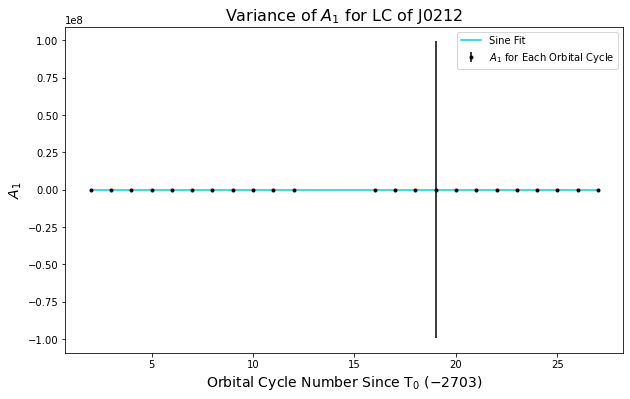

In [74]:
A_params_new = []
Cycle_number_new = []
A_cov_params_new = []
F_params_new = []

#J0212
for i in (1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24,25,26):
    A_params_new = np.append(A_params_new, A_params[i])
    Cycle_number_new = np.append(Cycle_number_new, Cycle_Number[i])
    A_cov_params_new = np.append(A_cov_params_new, A_cov_params[i])
    F_params_new = np.append(F_params_new, F_params[i])

#J0523
#for i in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37):
#    A_params_new = np.append(A_params_new, A_params[i])
#    Cycle_number_new = np.append(Cycle_number_new, Cycle_Number[i])
#    A_cov_params_new = np.append(A_cov_params_new, A_cov_params[i])

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

averageflux = np.mean(nan_tidied_flux)

#A = 1
B = 40
C = 1
D = averageflux

A = np.mean(A_params_new)
#B = 40
#C = np.mean(C_params_new)
#D = averageflux

init_vals = [A,B,C,D]

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, A_params_new, init_vals)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)

plt.figure(figsize=(10, 6))
plt.plot(Cycle_number_new, y_fit, label="Sine Fit", color='#02D1D6')
plt.errorbar(Cycle_number_new, A_params_new, yerr=A_cov_params_new, fmt='k.', ecolor='k', label=r"$A_1$ for Each Orbital Cycle")
plt.title(r"Variance of $A_1$ for LC of J0212", size=16)
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel, size=14)
plt.ylabel(r"$A_1$", size=14)

plt.legend()
plt.show()

In [75]:
A_spot_over_A_stellar = ( (2*(3.692623547446929))/95.0 ) / (1 - (5500.0/6000.0)**4)
print(A_spot_over_A_stellar)

0.2644799166870498


In [76]:
print(A_cov)

[ 83.41406625   2.12249759   0.13227755 -14.61235273]


In [ ]:
B_cov[1] * P

Testing C (phase offset of first harmonic) parameters:

Fitted parameters for sine curve: A=-2074.1692616712307, B=-4209.018642785202, C=-4.725994119771101, D=2076.0735885895915 



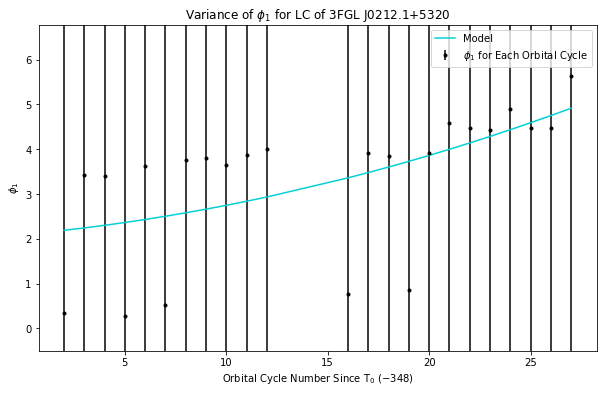

In [33]:
C_params_new = []
C_cov_params_new = []
#J0212
for i in (1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24,25,26):
    C_params_new = np.append(C_params_new, C_params[i])
    C_cov_params_new = np.append(C_cov_params_new, C_cov_params[i])

#J0523    
#for i in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37):
#    C_params_new = np.append(C_params_new, C_params[i])
#    C_cov_params_new = np.append(C_cov_params_new, C_cov_params[i])

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

averageflux = np.mean(nan_tidied_flux)
#J0212
A = 1
B = 40
C = 1
D = averageflux
#J0523
#A = np.mean(A_params_new)
#B = 40
#C = np.mean(C_params_new)
#D = averageflux

init_vals = [A,B,C,D]

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, C_params_new, init_vals)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)

plt.figure(figsize=(10, 6))

plt.plot(Cycle_number_new, y_fit, label="Model", color='#02D1D6')
plt.errorbar(Cycle_number_new, C_params_new, yerr=C_cov_params_new, fmt='k.', ecolor='k', label=r"$\phi_1$ for Each Orbital Cycle")
plt.title(r"Variance of $\phi_1$ for LC of "  + str(system_name) )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel)
plt.ylabel(r"$\phi_1$")
plt.ylim(- 0.5,2*np.pi + 0.5)
plt.legend()
plt.show()


Testing D parameters (amplitude of second harmonic)

Fitted parameters for sine curve: A=-1.6384208956261754, B=41.1590781431294, C=0.5329145748134796, D=28.67209751699483 

Variance in D: 5.055401439819661


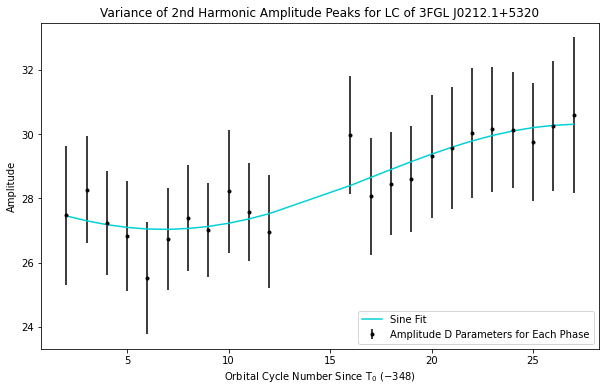

In [111]:
D_params_new = []
D_cov_params_new = []
#J0212
for i in (1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24,25,26):
    D_params_new = np.append(D_params_new, D_params[i])
    D_cov_params_new = np.append(D_cov_params_new, D_cov_params[i])
    
#J0523    
#for i in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37):
 #   D_params_new = np.append(D_params_new, D_params[i])
  #  D_cov_params_new = np.append(D_cov_params_new, D_cov_params[i])

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

average_amp = np.mean(D_params_new)
#Random for A,C=1
#J0212
#A = 1
B = 40
#C = 1
#D = averageflux

#J0523
A = np.mean(A_params_new)
#B = 3.5
C = np.mean(C_params_new)
D = averageflux

init_vals = [A,B,C,D]
bounds = (-np.pi,(np.inf,np.inf,np.inf,np.inf))  ######## Breaks down when adding in the bounds, same as single sine model below

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, D_params_new, init_vals)#, nan_tidied_errors)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

print("Variance in D:", np.max(D_params_new) - np.min(D_params_new))

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)

plt.figure(figsize=(10, 6))
plt.plot(Cycle_number_new, y_fit, label="Sine Fit", color='#02D1D6')
plt.errorbar(Cycle_number_new, D_params_new, yerr=D_cov_params_new, fmt='k.', ecolor='k', label="Amplitude D Parameters for Each Phase")
plt.title("Variance of 2nd Harmonic Amplitude Peaks for LC of " + str(system_name) )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel)
plt.ylabel("Amplitude")

plt.legend(loc='lower right')
plt.show()


# References

[1] K. I. Perez, S. Bogdanov, J. P. Halpern, V. Gajjar, Green Bank Telescope Discovery of the Redback Binary Millisecond Pulsar PSR J0212+5321, *The Astrophysical Journal* **952** 150 (2023)

[2] J. Strader, L. Chomiuk, E. Sonbas, K. Sokolovsky, D. J. Sand, A. S. Moskvitin, C. C. Cheung, 1FGL J0523.5−2529: A NEW PROBABLE GAMMA-RAY PULSAR BINARY, *The Astrophysical Journal Letters*, **788** L27 (2014)

[3] J. Vanderplas, A. Connolly, Z. Ivezic, A. Gray,“ Introduction to astroML: Machine learning for astrophysics”, *Proceedings of the Conference on Intelligent Data Understanding 2012*, 47-54 (2012)

[4] J. Vanderplas, Z. Ivezic, “Periodograms for Multiband Astronomical Time Series”, *The Astrophysical Journal*, **812** 1:18 (2015)

[5] C. Clark, L. Nieder, G. Voisin, B. Allen, C. Aulbert, O. Behnke, R. Breton, C. Choquet, A. Corongiu, V. Dhillon, H. B. Eggenstein, H. Fehrmann, L. Guillemot, A. Harding, M. Kennedy, B. Machenschalk, T. Marsh, D. Sánchez, R. Mignani, J. Wu, “Einstein@Home discovery of the gamma-ray millisecond pulsar PSR J2039–5617 confirms its predicted redback nature”, *Monthly Notices of the Royal Astronomical Society*, **502** 915–934 (2021)